# Experimental Holography

`slmsuite` targets _experimental_ holography on physical hardware.
In this example, we show how to connect to a camera and an SLM and
calibrate the transformation between the camera's space and the SLM's $k$-space.

The setup running this notebook (and the notebooks for other examples) is very simple.
From the left in the below diagram, we have an input laser which is expanded to the size of the SLM.
This light reflects from the SLM, exits the alternate port of a 50:50 beamsplitter, and
reaches the camera. Importantly, a lens is positioned inbetween the camera and SLM with
a distance corresponding to the focal length $f$ from each. Thus, the camera's imaging plane is the
farfield of the SLM (also called Fourier domain or $k$-space of the SLM).
Note that this setup is simple, but is not necessarily optimal for a given application.
Interrogating the SLM at a shallow angle, for instance, will avoid stray reflections and the
75% efficiency hit.

![Setup diagram](https://raw.githubusercontent.com/QPG-MIT/slmsuite-examples/main/examples/setup_diagram.png)

<!-- <p style="text-align: center">
    <img src="setup_diagram.png" width="600" style="display=block; margin:auto"/>
</p>
<p style="text-align: center">
    <i>A diagram of the SLM setup used for these examples.</i>
</p> -->

In [1]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path (For the case where it isn't installed via pip).
# slmsuite-examples is assumed to be installed in the same directory as slmsuite.
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

#### Loading Hardware

**Cameras** and **SLMs** are connected to python by a myriad of SDKs, often provided by hardware
vendors. However, these SDKs likewise have a myriad of function names and hardware-specific
quirks. Thus, hardware in `slmsuite` is integrated as subclasses of
the abstract classes `.Camera` and `.SLM`.
These subclasses for [cameras](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.html) 
and [slms](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.html)
are effectively wrappers for given SDKs, implemented with standardized methods and
syntax that the rest of `slmsuite` can understand, but  also include quality-of-life
features. SLMs that do not have a display SDK are often interfaced to via a virtual
screen, and the `ScreenMirrored` class projects phase onto these.
If you believe your camera or SLM is not supported by the currently available classes, please 
[open a GitHub issue](https://github.com/QPG-MIT/slmsuite/issues) 
or [feel free to write an interface yourself](https://github.com/QPG-MIT/slmsuite/blob/main/CONTRIBUTING.md)!

First, let's load an SLM. We're running this notebook with a `Santec` SLM.
We can find connected displays with the `.info()` static method.

In [2]:
# **README**                        (This cell is hidden from readthedocs rendering)
# If you're reading this, you might have gotten an error from loading physical
# hardware in the next cell, but that doesn't mean you can't run this notebook!
# This cell loads virtual hardware. You can proceed to the Simple Holography section.
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.hardware.slms.simulated import SimulatedSLM
from slmsuite.hardware.cameras.simulated import SimulatedCamera

# Make the SLM and camera.
slm = SimulatedSLM((1920, 1200), pitch_um=(8,8))
slm.set_source_analytic(sim=True)               # Program the virtual source.
slm.set_source_analytic()                       # Don't bother with wavefront calibration, instead just set it to the same source.

cam = SimulatedCamera(slm, (1440, 1100), pitch_um=(4,4), gain=50)

# Tie the camera and SLM together with an analytic Fourier calibration.
fs = FourierSLM(cam, slm)
M, b = fs.fourier_calibration_build(
    f_eff=80000.,                               # f_eff of 80000 wavelengths or 80 mm with the default 1 um wavelength
    theta=5 * np.pi / 180,                      # Slight rotation for fun.
)
fs.fourier_calibrate_analytic(M, b)

In [3]:
from slmsuite.hardware.slms.santec import Santec
Santec.info(verbose=True);

Displays detected by Santec
display_number, display_name:
1,  S24B150,SAM,0983,HTLF100868
2,  LCOS-SLM,SOC,8001,2018021001


We see that `display_number=2` is the display with the LCoS SLM. We're running this setup with a 633 nm HeNe laser. Setting the wavelength `wav_um` to the correct value is critical for ideal performance; there are optimizations and conversions under the hood that need the wavelength of interest. 
We also supply a settle time in seconds for the SLM (`settle_time_s`). While some SLMs can update at 100s of hertz, the time required for a precise hologram to settle far past the `1/e` point is often much longer.
We take care to extensively document our functions, including the below 
[initializer](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.santec.Santec.html#slmsuite.hardware.slms.santec.Santec.__init__).

In [4]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.3)

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success


Next, let's load a camera. We're running this notebook with a `AlliedVision` camera. We can find connected cameras with the `.info()` static method.

In [5]:
from slmsuite.hardware.cameras.alliedvision import AlliedVision
AlliedVision.info(verbose=True);

AlliedVision serials:
'02C5V'


We want the `"02C5V"` serial.

In [6]:
cam = AlliedVision(serial="02C5V")

vimba initializing... success
Looking for cameras... success
vimba sn '02C5V' initializing... success


Lastly, we'll make a [class for our composite optical system](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM), 
consisting of the camera and the SLM. We'll also load a previously-measured 
[wavefront calibration](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM.wavefront_calibrate)
(we'll come back to this in a later example!).

smooth:   0%|          | 0/16 [00:00<?, ?it/s]

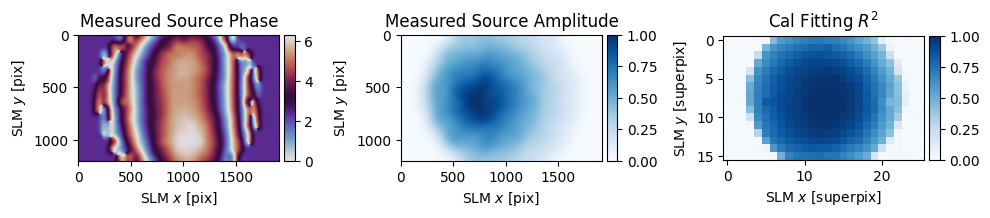

In [7]:
from slmsuite.hardware.cameraslms import FourierSLM
fs = FourierSLM(cam, slm)
fs.read_calibration("wavefront_superpixel");    # We'll come back to this!
fs.wavefront_calibration_superpixel_process(plot=True, r2_threshold=.5);

#### Simple Holography

Let's start out with the simplest phase pattern possible: no pattern! We 
[write](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.slm.SLM.html#slmsuite.hardware.slms.slm.SLM.write) 
a flat phase $\phi(\vec{x}) = 0\pi$ to the SLM with `.set_phase()`.

In [ ]:
phase = np.zeros(slm.shape)
slm.set_phase(phase, settle=True);      # slm.set_phase(None, settle=True) is equivalent to this.

Great. Let's [take a look](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.camera.Camera.html#slmsuite.hardware.cameras.camera.Camera.get_image)
at the result in our camera with `.get_image()`. We'll also set the exposure to an appropriate value.

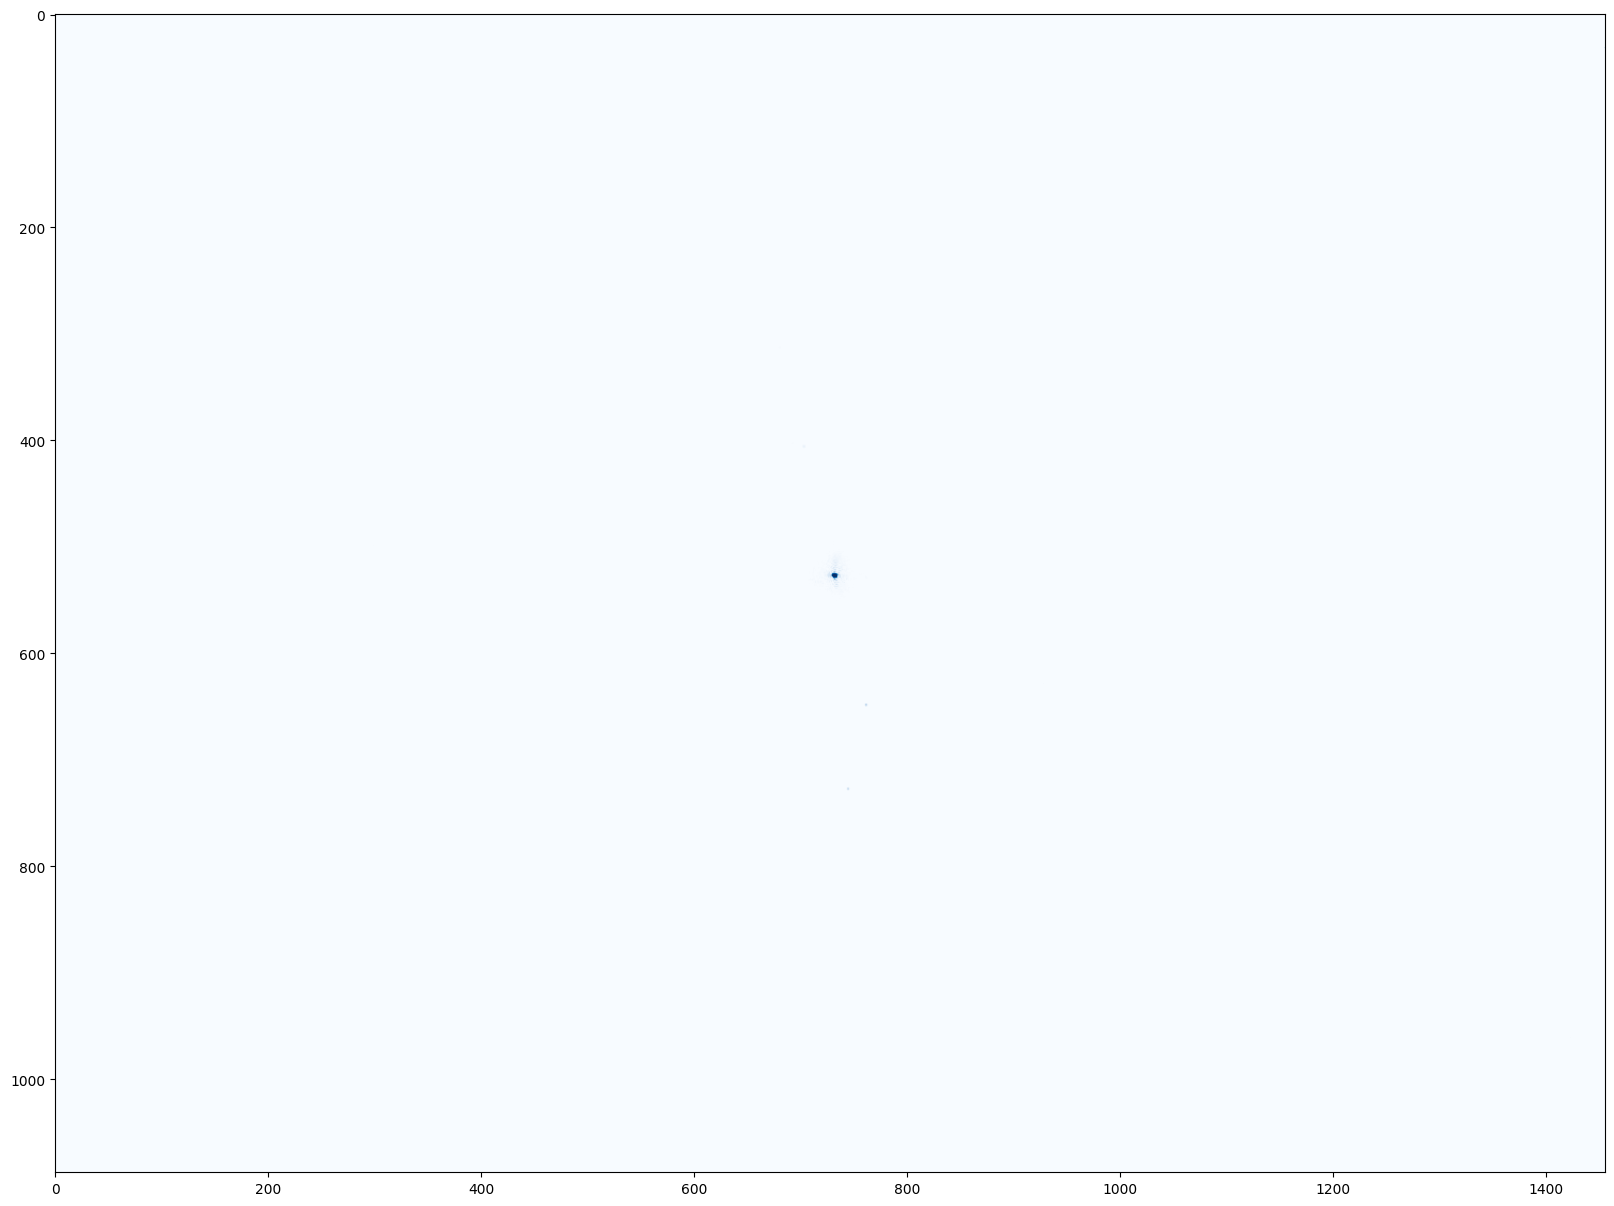

In [9]:
cam.set_exposure(.002)
img = cam.get_image()

# Plot the result
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.show()

We see a spot corresponding to the zero-th order diffraction peak (i.e. undiffracted
because no phase is written). This spot is focussed at the center of our camera.

Next, we'll move the laser spot by applying a 
[blazed grating](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.blaze.html#slmsuite.holography.toolbox.blaze)
to the SLM using a helper function from our `toolbox`. This blazed grating has a Fourier
spectrum shifted from the origin, so naturally applying this pattern to the SLM will
produce a shifted result in the farfield, i.e. in the plane of the camera. Note that the
phase pattern is in units of phase (units of $2\pi$). This is then translated into the
integer data that is actually displayed on the SLM (see `.set_phase()` or `._phase2gray()`).
If one passes integer `phase` to the SLM in `.set_phase()`, then this data is displayed
directly, but any float data is interpreted as a phase. As an additional subtlety, most
SLMs have an "increasing integer value, increasing voltage, decreasing phase"
convention, so any passed phase is inverted in sign before displaying to have the
correct convention.

Many common phases patterns are available in the `slmsuite.holography.toolbox.phase`
module, alongside `blaze()`. See the Structured Light example for more information (e.g.
the behavior of `grid=`).

We're going to be `.set_phase()`ing `.get_image()`ing a couple more times in
this notebook, so we'll use the helper function `fs.plot()` to simplify plotting. One can
also use `cam.plot()` and `slm.plot()` to plot the phase and amplitudes alone.

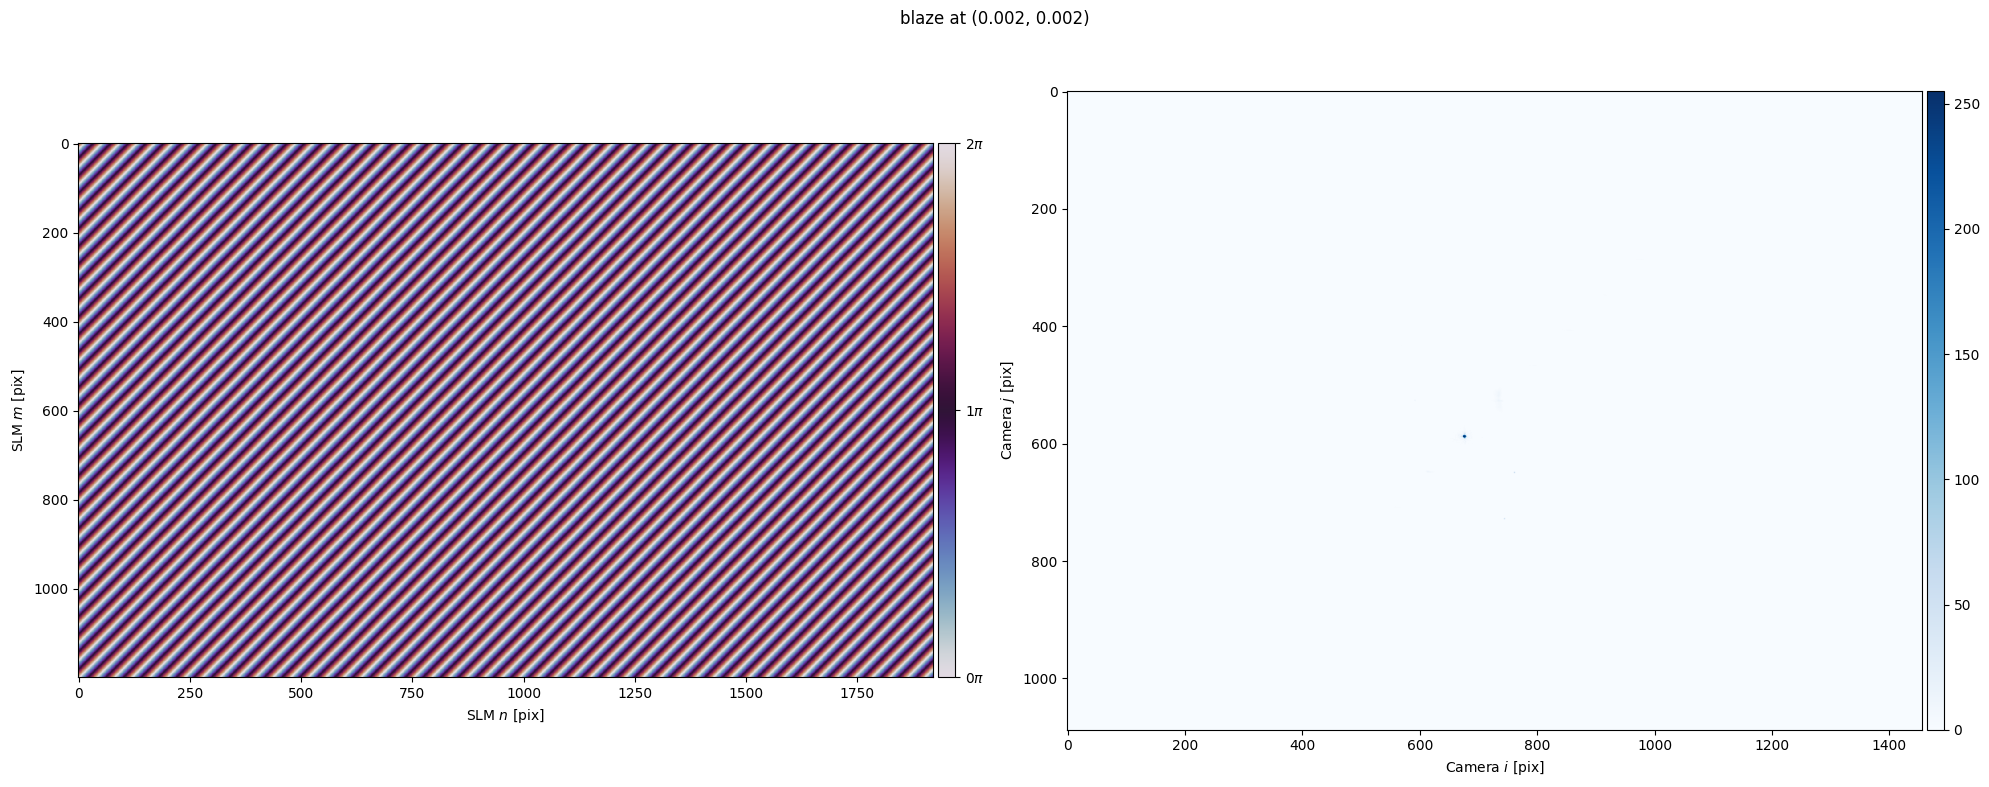

In [10]:
from slmsuite.holography import toolbox

vector = (.002, .002)                                       # Radians (== normalized units kx/k).
blaze_phase = toolbox.phase.blaze(grid=slm, vector=vector)  # Phase in units of 2pi.

fs.plot(blaze_phase, title="blaze at {}".format(vector));

But what units does `vector` have? The default blaze units in `slmsuite` (`"norm"`) are normalized $k_x/k$ units, which are equivalent to radians in the small angle approximation. To get a better handle on what `vector = (.002, .002)` means, we can 
[print](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.print_blaze_conversions.html#slmsuite.holography.toolbox.print_blaze_conversions)
the equivalent vectors converted to supported units with `toolbox.print_blaze_conversions()` (n.b. `"ij"` is not yet calibrated so it cannot be converted).

In [11]:
toolbox.print_blaze_conversions(vector=(.002, .002), from_units="norm", hardware=slm)

'rad' : [0.002 0.002]
'mrad' : [2. 2.]
'deg' : [0.11459156 0.11459156]
'norm' : [0.002 0.002]
'kxy' : [0.002 0.002]
'knm' : [1008.53080569  630.33175355]
'freq' : [0.02527646 0.02527646]
'lpmm' : [3.15955766 3.15955766]
'zernike' : [118.85731333 118.85731333]
'ij' : [nan nan]
'm' : [nan nan]
'cm' : [nan nan]
'mm' : [nan nan]
'um' : [nan nan]
'nm' : [nan nan]
'mag_m' : [nan nan]
'mag_cm' : [nan nan]
'mag_mm' : [nan nan]
'mag_um' : [nan nan]
'mag_nm' : [nan nan]


So we're diffracting light by an angle of two milliradians or a tenth of a degree.
You can read more about all the units in the [documentation](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.convert_vector.html#slmsuite.holography.toolbox.convert_vector).
Notice that some of the units are `nan`. This is because we haven't yet calibrated some needed conversions related to the
relationship between the SLM's $k$-space and the camera's pixel space, but more on that next section.

This function wraps `toolbox.convert_vector()` which handles arbitrary unit conversions. Let's try it out by diffracting light at .2 degrees in the $x$ and $y$ directions.

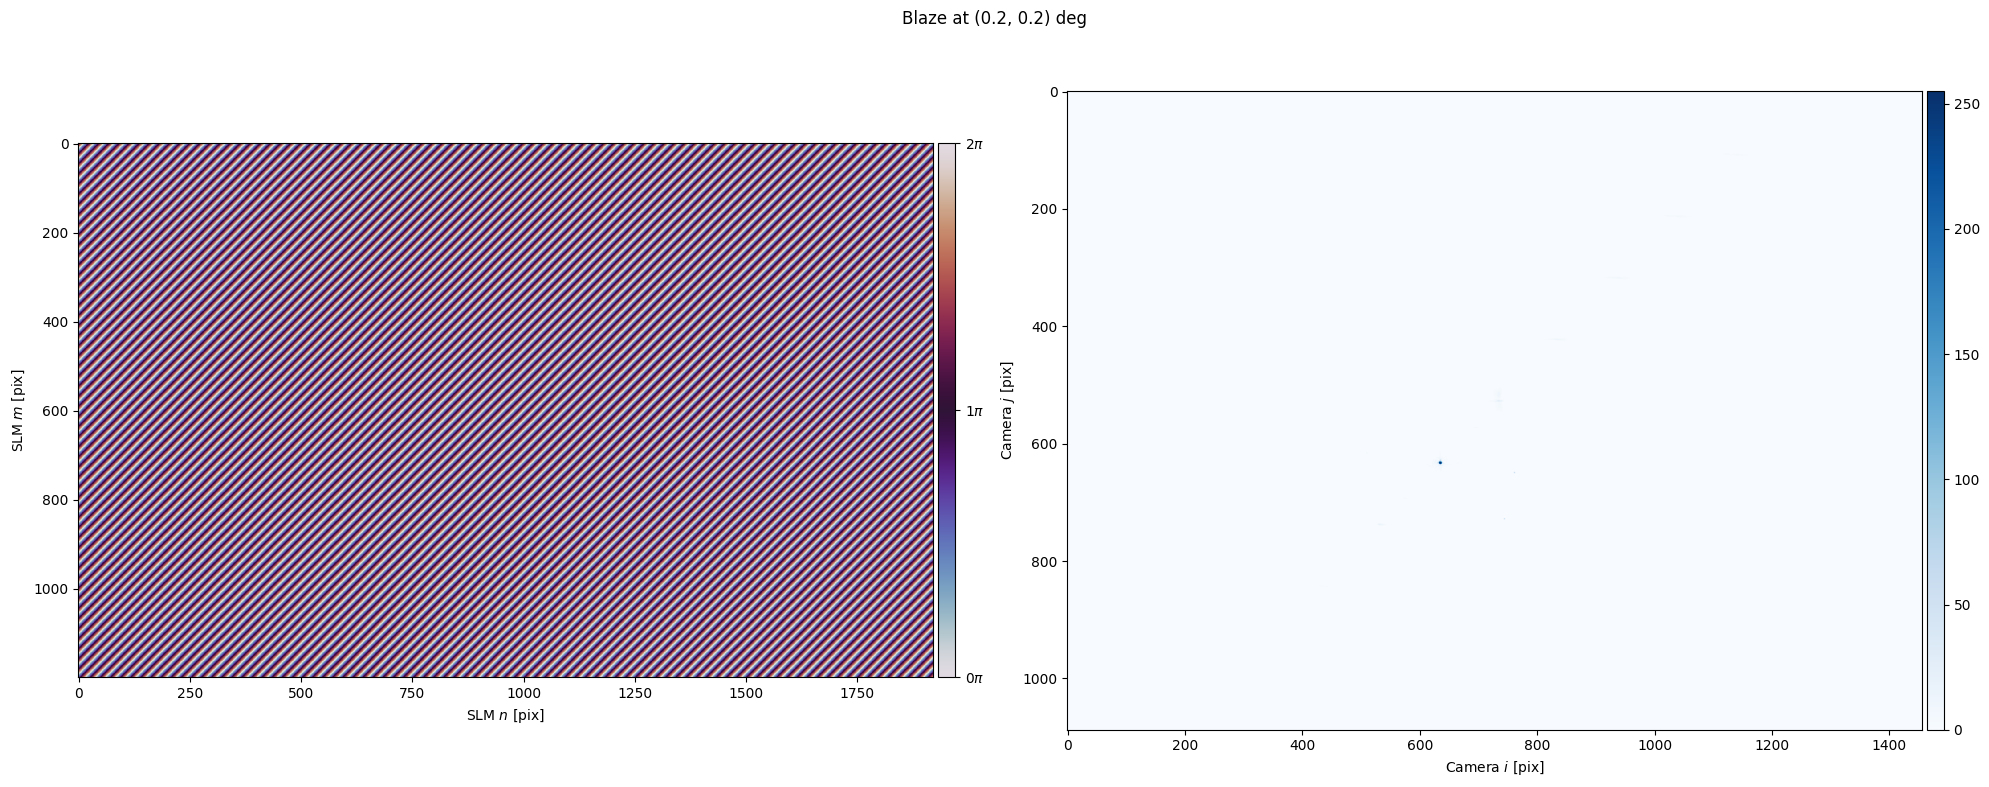

In [12]:
# Get .2 degrees in normalized units.
vector_deg = (.2, .2)
vector = toolbox.convert_blaze_vector(vector_deg, from_units="deg", to_units="norm")

# Get the phase for the new vector
blaze_phase = toolbox.phase.blaze(grid=slm, vector=vector)

fs.plot(blaze_phase, title="Blaze at {} deg".format(vector_deg));

All this is good fun, but let's say we wanted our spot right at pixel `(500, 700)`. We could iterate by guessing and checking successive `vectors`, but that seems boring and non-pythonic. Instead, we will calibrate a transformation between the $k$-space of the SLM and the space of the camera using features built-in to `slmsuite`.

#### Fourier Calibration

Calibration is simple, just run a built-in function `.fourier_calibrate()` to 1) generate and 2) fit a grid of spots (with known $k$-space coordinates) with an affine transformation to the space of the camera. This grid is generated using the same holography algorithms we explored in the [computational holography](https://slmsuite.readthedocs.io/en/latest/_examples/computational_holography.html) tutorial. We'll come back to experimental implementations of these shortly; for now, care must be taken to choose:

 - A camera exposure such that spots are prominent,
 - A pitch and shape of the array which are visually resolvable.

Note that the default array units are in `"knm"` space, or the 
[computational space of holography](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.algorithms.html). 
Read more about this in later examples.

  0%|          | 0/10 [00:00<?, ?it/s]

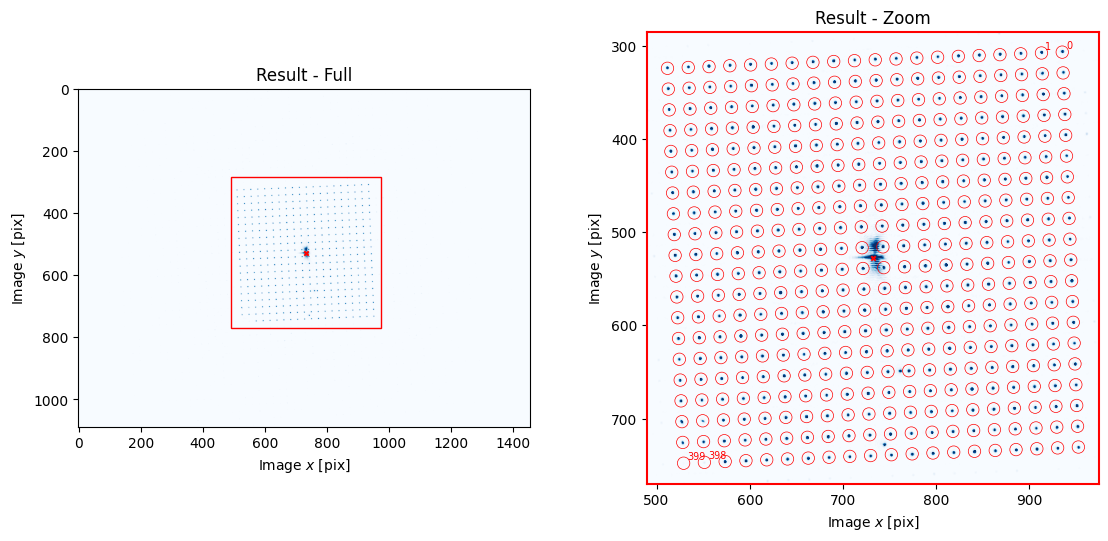

In [13]:
cam.set_exposure(.05)               # Increase exposure because power will be split many ways

fs.fourier_calibrate(
    array_shape=20,                 # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=20,                 # Pitch of the calibration grid (x, y) [knm]
    plot=True
)

cam.set_exposure(.0002)             # Restore exposure

Notice that there are two missing spots from the array. This is a parity check to make sure the calibration is flipped in the correct direction.

The result of this process is the transformation

$\vec{x} = M \cdot (\vec{k} - \vec{a}) + \vec{b}$

where $\vec{x}$ is in units of camera pixels and $\vec{k}$ is in units of normalized $k$-space. We can view the result in the `fourier_calibration` variable.

In [14]:
fs.calibrations["fourier"]

{'M': array([[-28840.71822606,   1178.10823299],
        [  1182.11277757,  28850.24040551]]),
 'b': array([[732.12741244],
        [527.48959233]]),
 'a': array([[-8.76122968e-21],
        [ 5.60718699e-19]]),
 '__version__': '0.1.0',
 '__time__': '2024-07-25 23:37:53.376531',
 '__timestamp__': 1721965073.376531,
 '__meta__': {'camera': '02C5V', 'slm': '2018021001'}}

Now let's use this calibration to achieve our goal of `(500, 700)`. We can find the blaze vector $\vec{k}$ (in normalized units) corresponding to the desired pixel $\vec{x}$ using our calibration.

In [15]:
vector_500_700 = fs.ijcam_to_kxyslm((500, 700))
print(vector_500_700)

[[0.008279  ]
 [0.00564029]]


Now let's check this result:

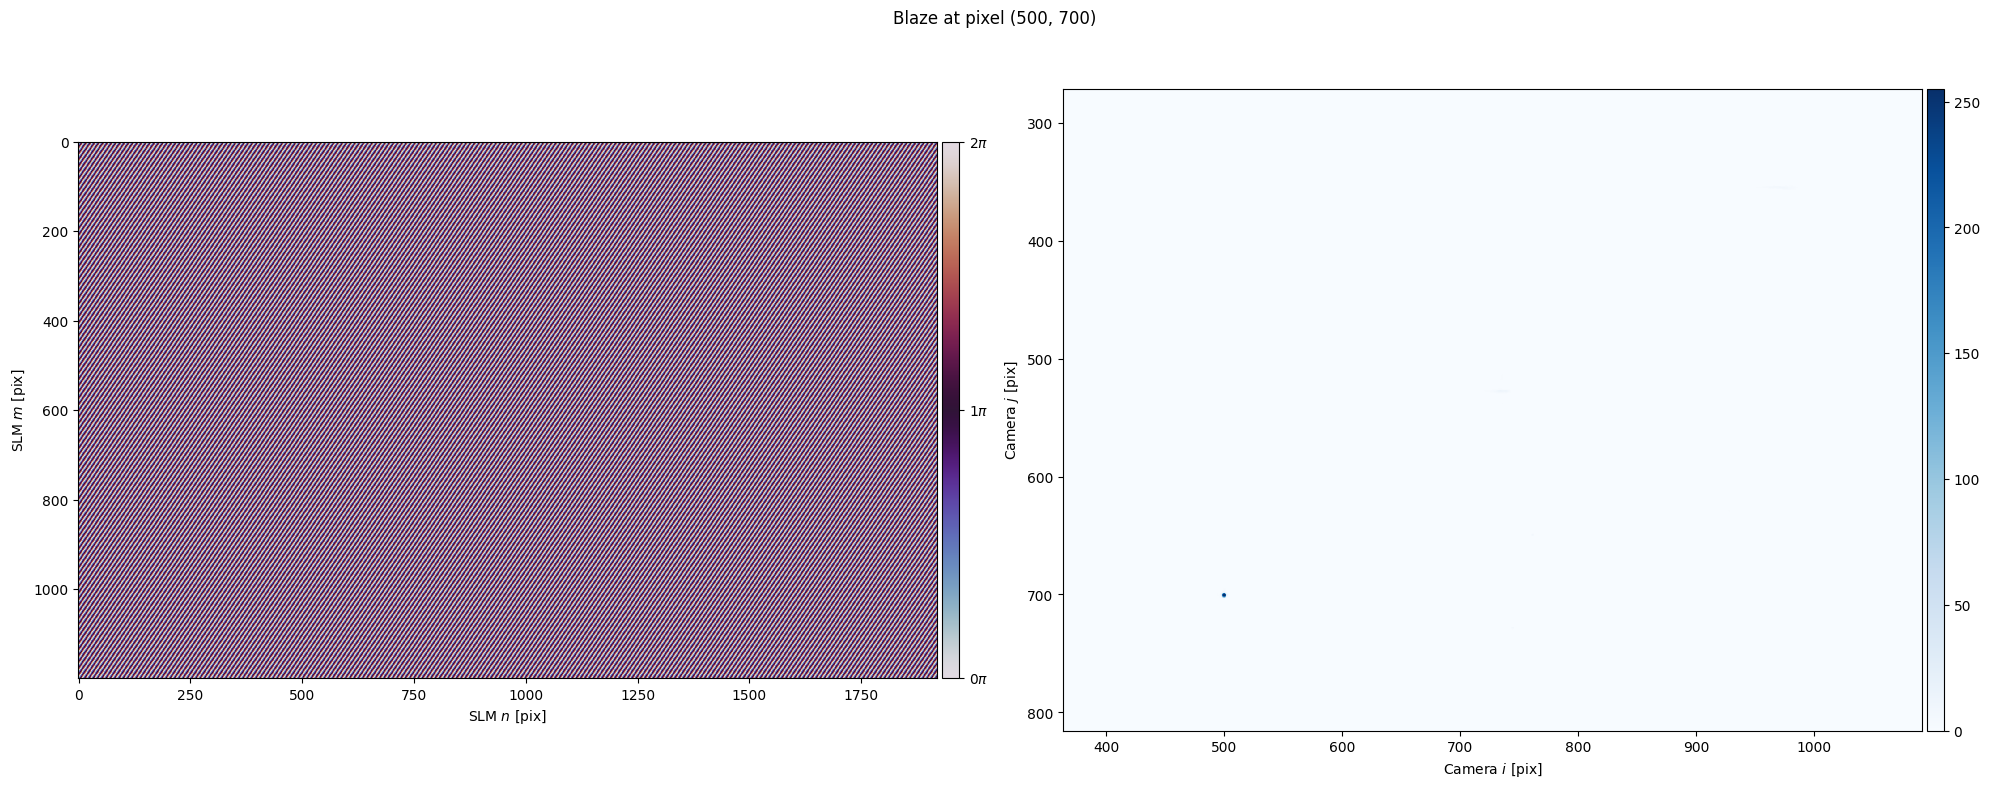

In [16]:
blaze_phase = toolbox.phase.blaze(grid=slm, vector=vector_500_700)

fs.plot(blaze_phase, title="Blaze at pixel (500, 700)", cam_limits=.5);

#### Spot Holography

The previous examples considered blazing light in one direction towards one point, but what if we want to generate patterns with many spots? Of course, this isn't as simple as adding the blaze phase patterns for $\vec{k}_1$ and $\vec{k}_2$, as this would just blaze light along $\vec{k} = \vec{k}_1 + \vec{k}_2$. Things are more complicated. This example will show how to generate `SpotHologram`s with `slmsuite`.



#### A Square Array and `take`

Let's consider a case where we want to fill part of our camera's space with a square array of spots, spaced with a pitch of 100 pixels.

[ 100  200  300  400  500  600  700  800  900 1000]


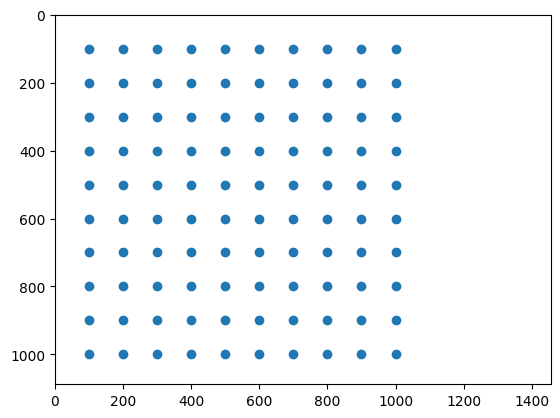

In [17]:
xlist = np.arange(100, min(fs.cam.shape), 100)                      # Get the coordinates for one edge
print(xlist)

xgrid, ygrid = np.meshgrid(xlist, xlist)
square = np.vstack((xgrid.ravel(), ygrid.ravel()))                  # Make an array of points in a grid

plt.scatter(square[0,:], square[1,:])                               # Plot the points
plt.xlim([0, fs.cam.shape[1]]); plt.ylim([fs.cam.shape[0], 0])
plt.show()

Making a hologram is simple. we initialize a hologram with a computational space of shape `(2048, 2048)`. This shape just has to be larger than the SLM shape, and should ideally consist of powers of two. We provide the points in the `"ij"` basis of our camera's pixels, made possible by the Fourier calibration passed via our `FourierSLM` named `fs`.

In [18]:
from slmsuite.holography.algorithms import SpotHologram
hologram = SpotHologram(shape=(2048, 2048), spot_vectors=square, basis='ij', cameraslm=fs)

This initialize just constructs datastructures, but does not conduct optimization.

We can first plot the target amplitudes at desired locations in the `"knm"` basis, which is needed to apply discrete Fourier transforms. Our Fourier calibration also shows us how our camera's field of view (in yellow) compares to the size of the computational space.

Next, we plot the amplitudes resulting from the initial conditions of optimization (random phase). This just looks like noise, as expected.

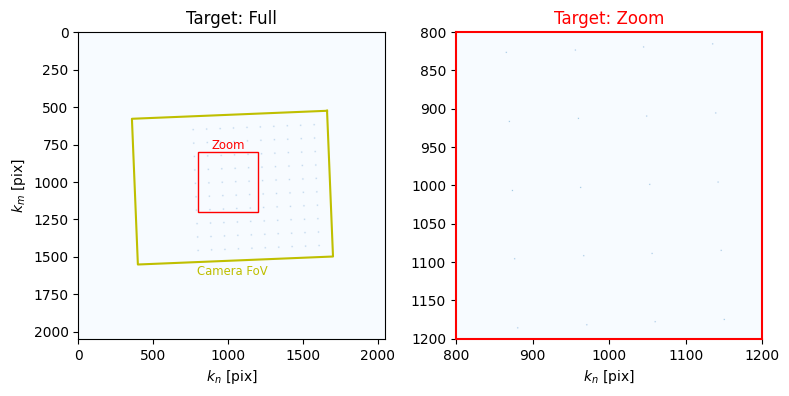

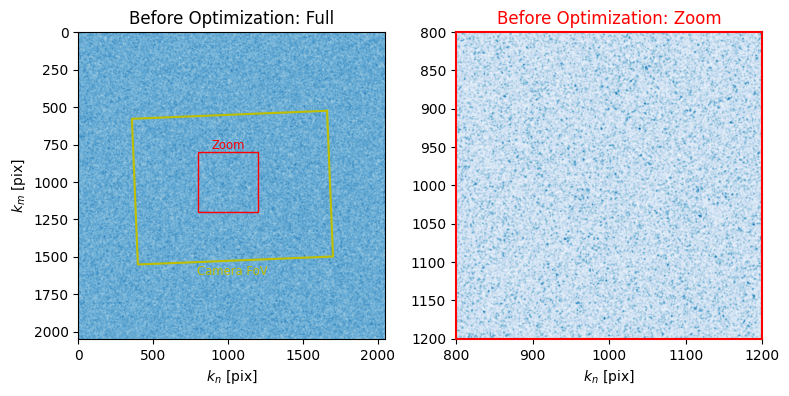

In [19]:
hologram.plot_farfield(hologram.target,  limits=[[800, 1200], [800, 1200]], title="Target")
hologram.plot_farfield(limits=[[800, 1200], [800, 1200]], title="Before Optimization");

This randomness won't last. We quickly take 50 iterations of optimization towards our target. Here, we use weighted [Gerchberg-Saxton](https://en.wikipedia.org/wiki/Gerchberg%E2%80%93Saxton_algorithm)-type algorithms to iteratively hone the nearfield phase pattern to produce the desired farfield at the camera. 

  0%|          | 0/50 [00:00<?, ?it/s]

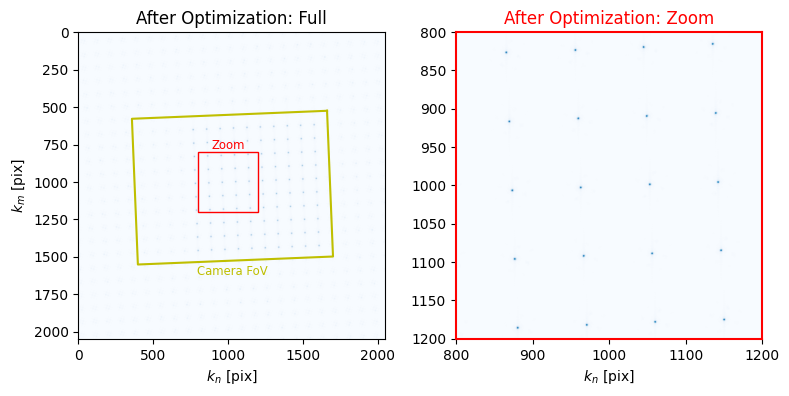

In [20]:
hologram.optimize('WGS-Kim', feedback='computational_spot', stat_groups=['computational_spot'], maxiter=50)
hologram.plot_farfield(limits=[[800, 1200], [800, 1200]], title="After Optimization");

Now the computed result of our optimized hologram roughly matches the target. The phase that generates this amplitude result in the farfield is plotted below. The amplitude pattern is an estimate of the real nearfield amplitude measured via wavefront calibration. Note that we plot both the system padded to the `(2048, 2048)` shape of the computational space (used during optimization) and the system cropped to the shape of the SLM (used in practice).

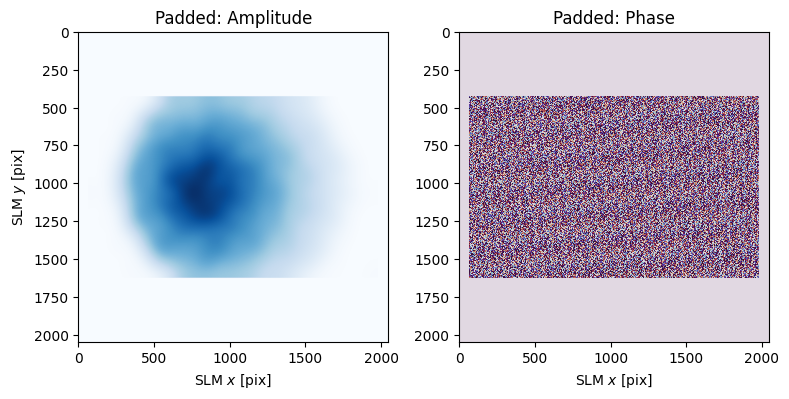

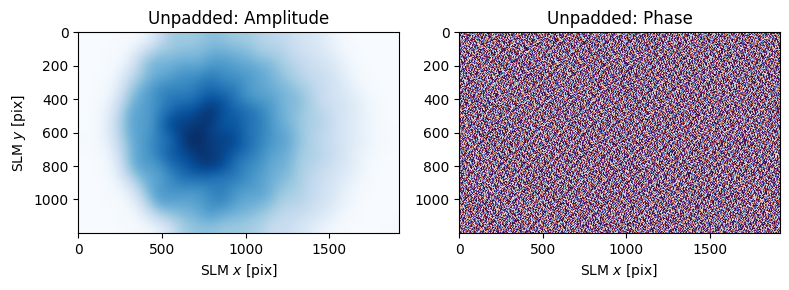

In [21]:
hologram.plot_nearfield(title="Padded", padded=True)
hologram.plot_nearfield(title="Unpadded")

Let's see how this looks experimentally.

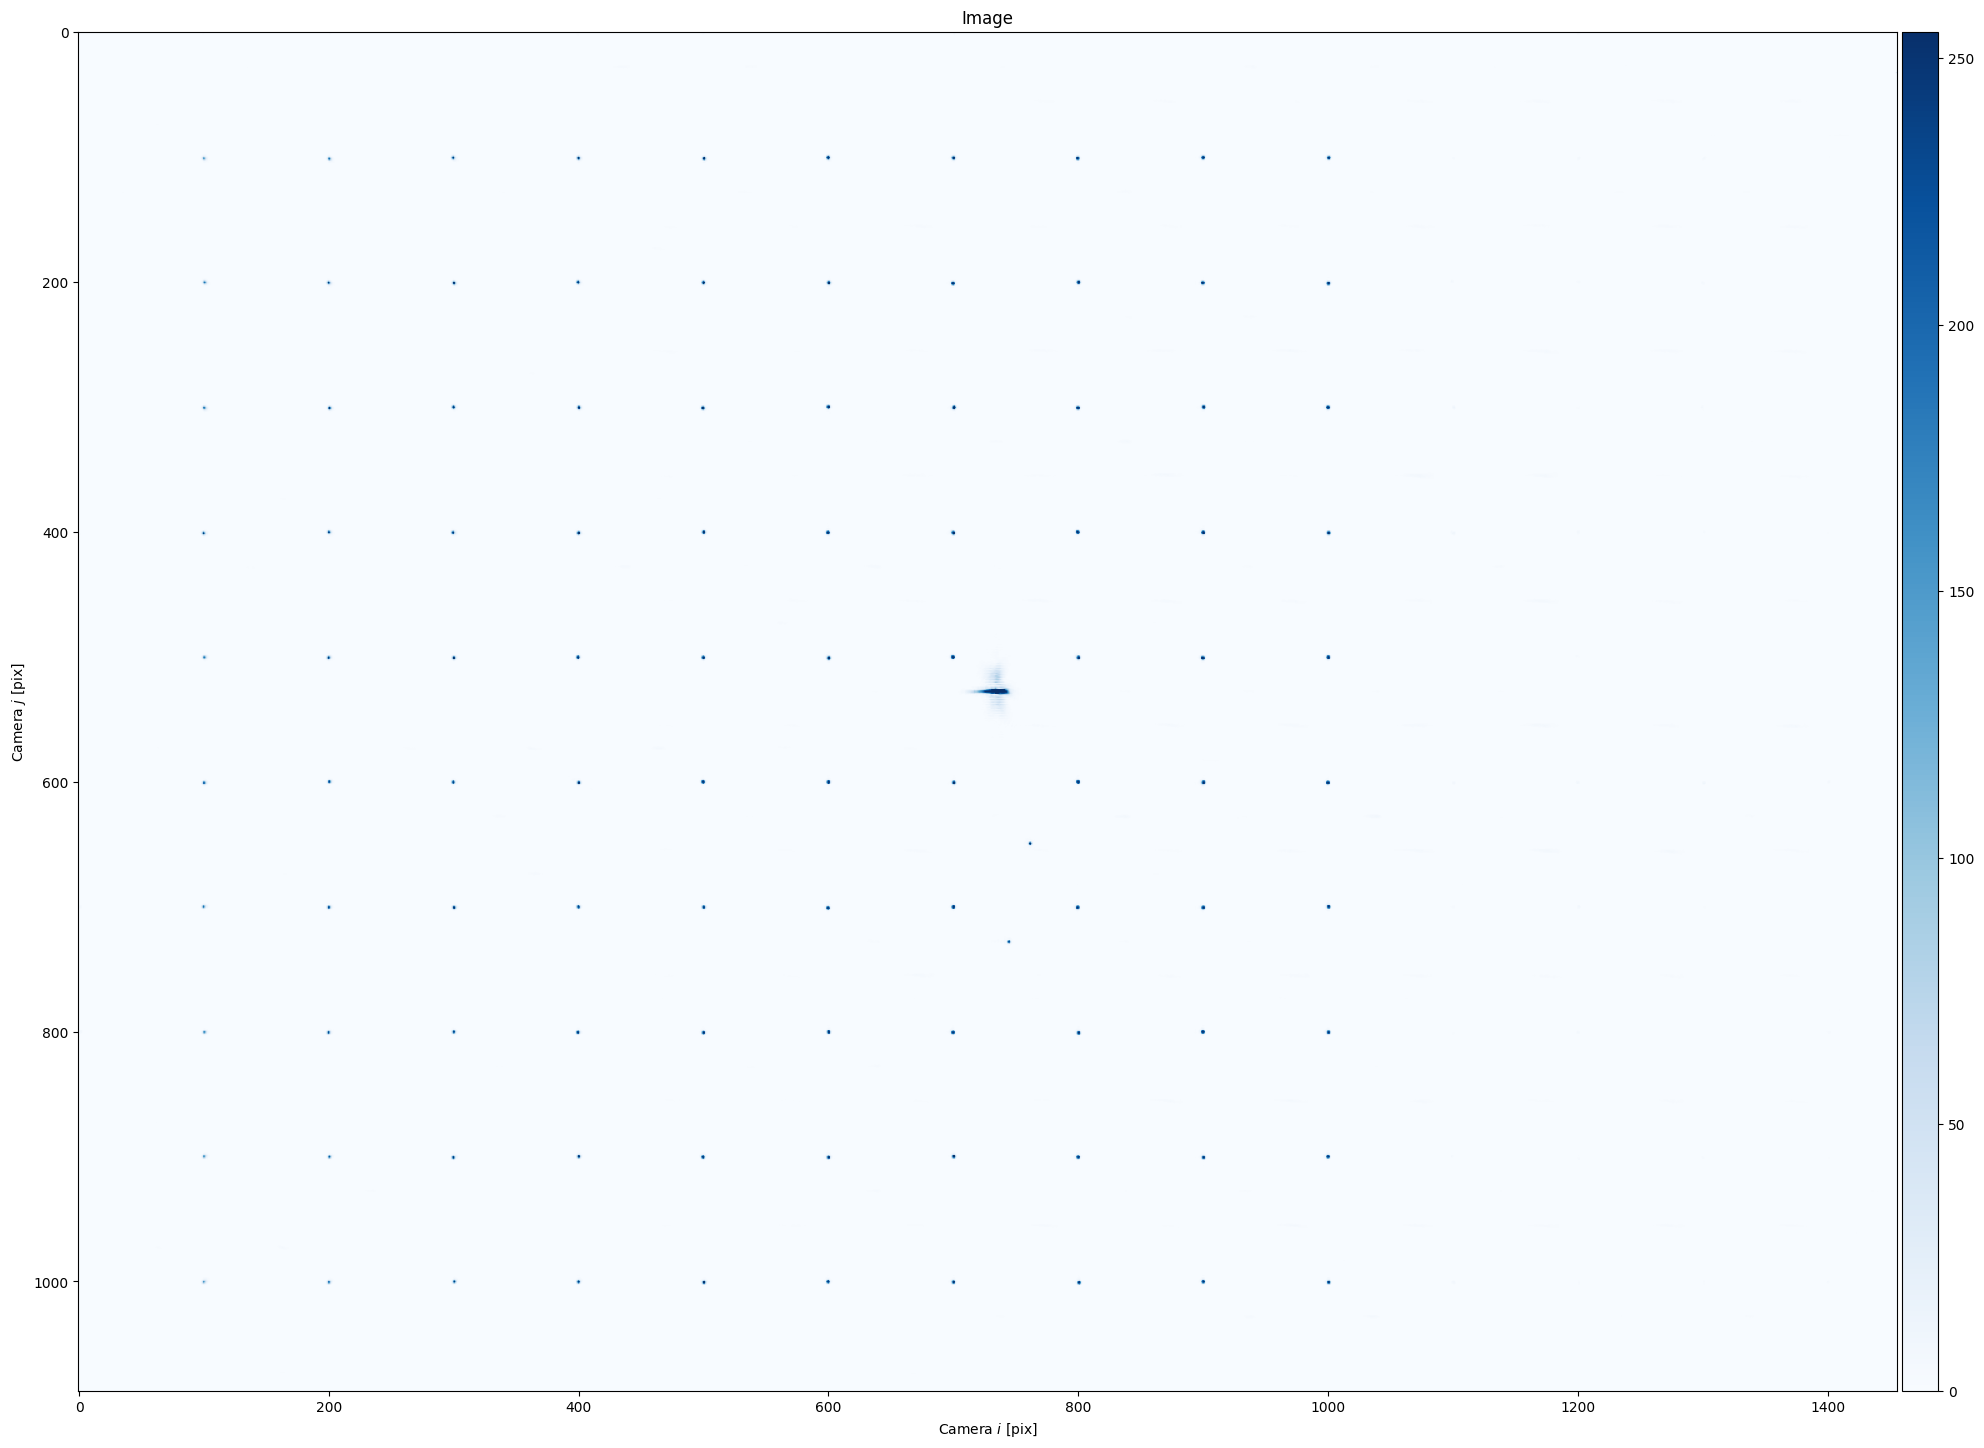

In [ ]:
fs.slm.set_phase(hologram.get_phase(), settle=True)                 # Write hologram.
fs.cam.set_exposure(.01)
fs.cam.flush()
img = fs.cam.get_image()                                        # Grab image.

plt.figure(figsize=(24,24))
fs.cam.plot(img);

Looks good! Those two extra spots below the zero-th order are due to reflections off of the 50:50 beamsplitter. A setup without a beamsplitter would not have these artifacts.

We can immediately see (even through the saturation) that the spots on the edges of the field of view are less bright. 
Let's `take()` a closer look at this making using of helper functions in the `analysis` module. 
The function `take()` is very useful to analyze spots. It crops an image into many windows with width `size` around a desired set of `vector`, in our case, the points at which we expects spots to appear. 
`take()` is written to be efficient, making heavy use of `numpy` parallelism, and has many useful
[options](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.analysis.take.html#slmsuite.holography.analysis.take).

We also plot the regions we took from the image using the `take_plot()` helper function.

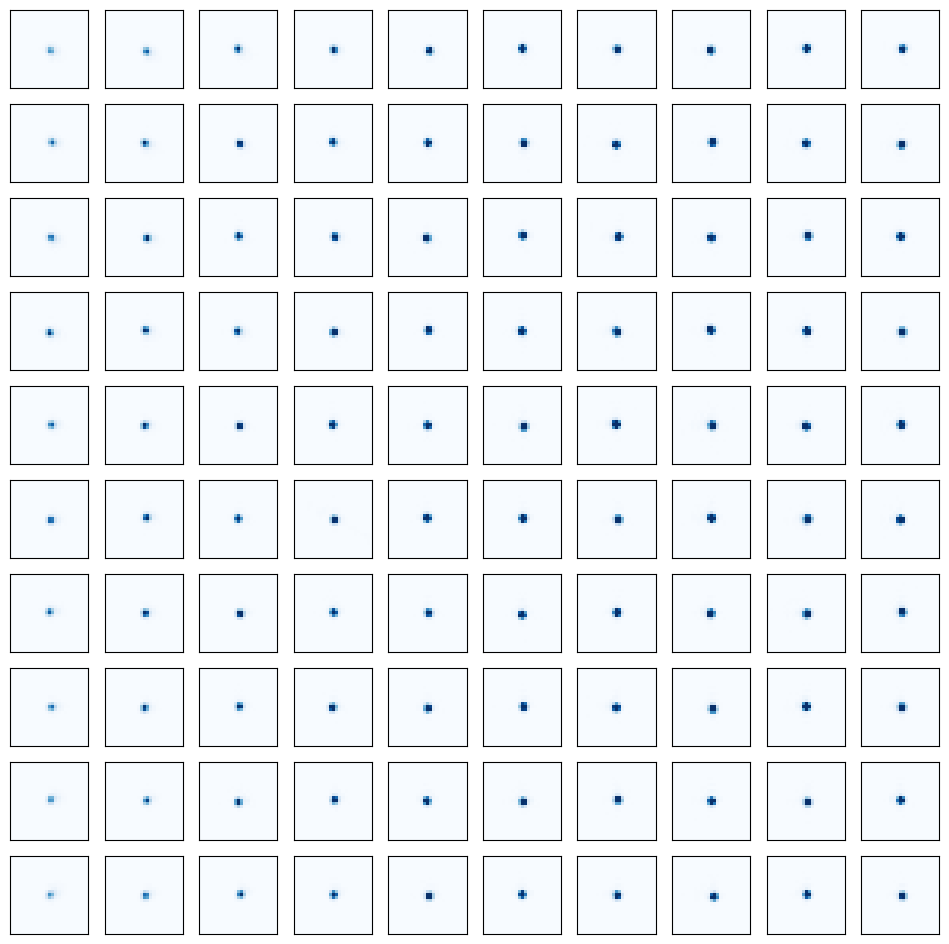

In [ ]:
from slmsuite.holography import analysis
subimages = analysis.take(img, vectors=square, size=25)
analysis.take_plot(subimages, separate_axes = True)

The spots are a pixel off in a few places, but a bigger issue is the uniformity. We can get a histogram of the spot powers with another helper function `image_normalization()`.

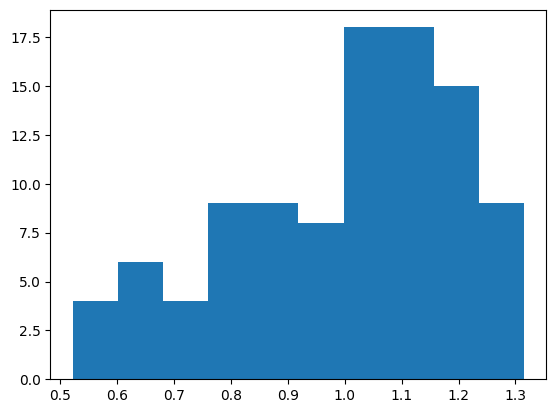

In [24]:
powers = analysis.image_normalization(subimages)
plt.hist(powers / np.mean(powers))
plt.show()

There's more than 60% variation across the array, largely from diffraction inefficiency closer to the field of view. This isn't surprising, as we're filling our camera with spots, and this area corresponds to nearly the full $k$-space of the SLM. In practice, the closer to the edge of the $k$-space one gets, the lower the efficiency due to sampling considerations. Fortunately, `slmsuite` is a package that considers the unification of SLMs and cameras, so we have a solution.

#### A Uniform Square Array

That solution is camera feedback. We can easily enable this by using the option to `feedback` upon the power at spots measured by the camera. This is enabled by switching to `"experimental_spot"` (versus `"computational_spot"`) feedback. Since the optimization with experimental feedback is a bit slower (we wait for the SLM to settle and for the camera to grab an image), we precondition our optimization computationally-optimized pattern.

In [25]:
hologram = SpotHologram(shape=(2048, 2048), spot_vectors=square, basis='ij', cameraslm=fs)

# Precondition computationally.
hologram.optimize(
    'WGS-Kim',
    maxiter=20,
    feedback='computational_spot',
    stat_groups=['computational_spot']
)
# Hone the result with experimental feedback.
hologram.optimize(
    'WGS-Kim',
    maxiter=20,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'],
    fixed_phase=False
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

And let's take a look at our result.

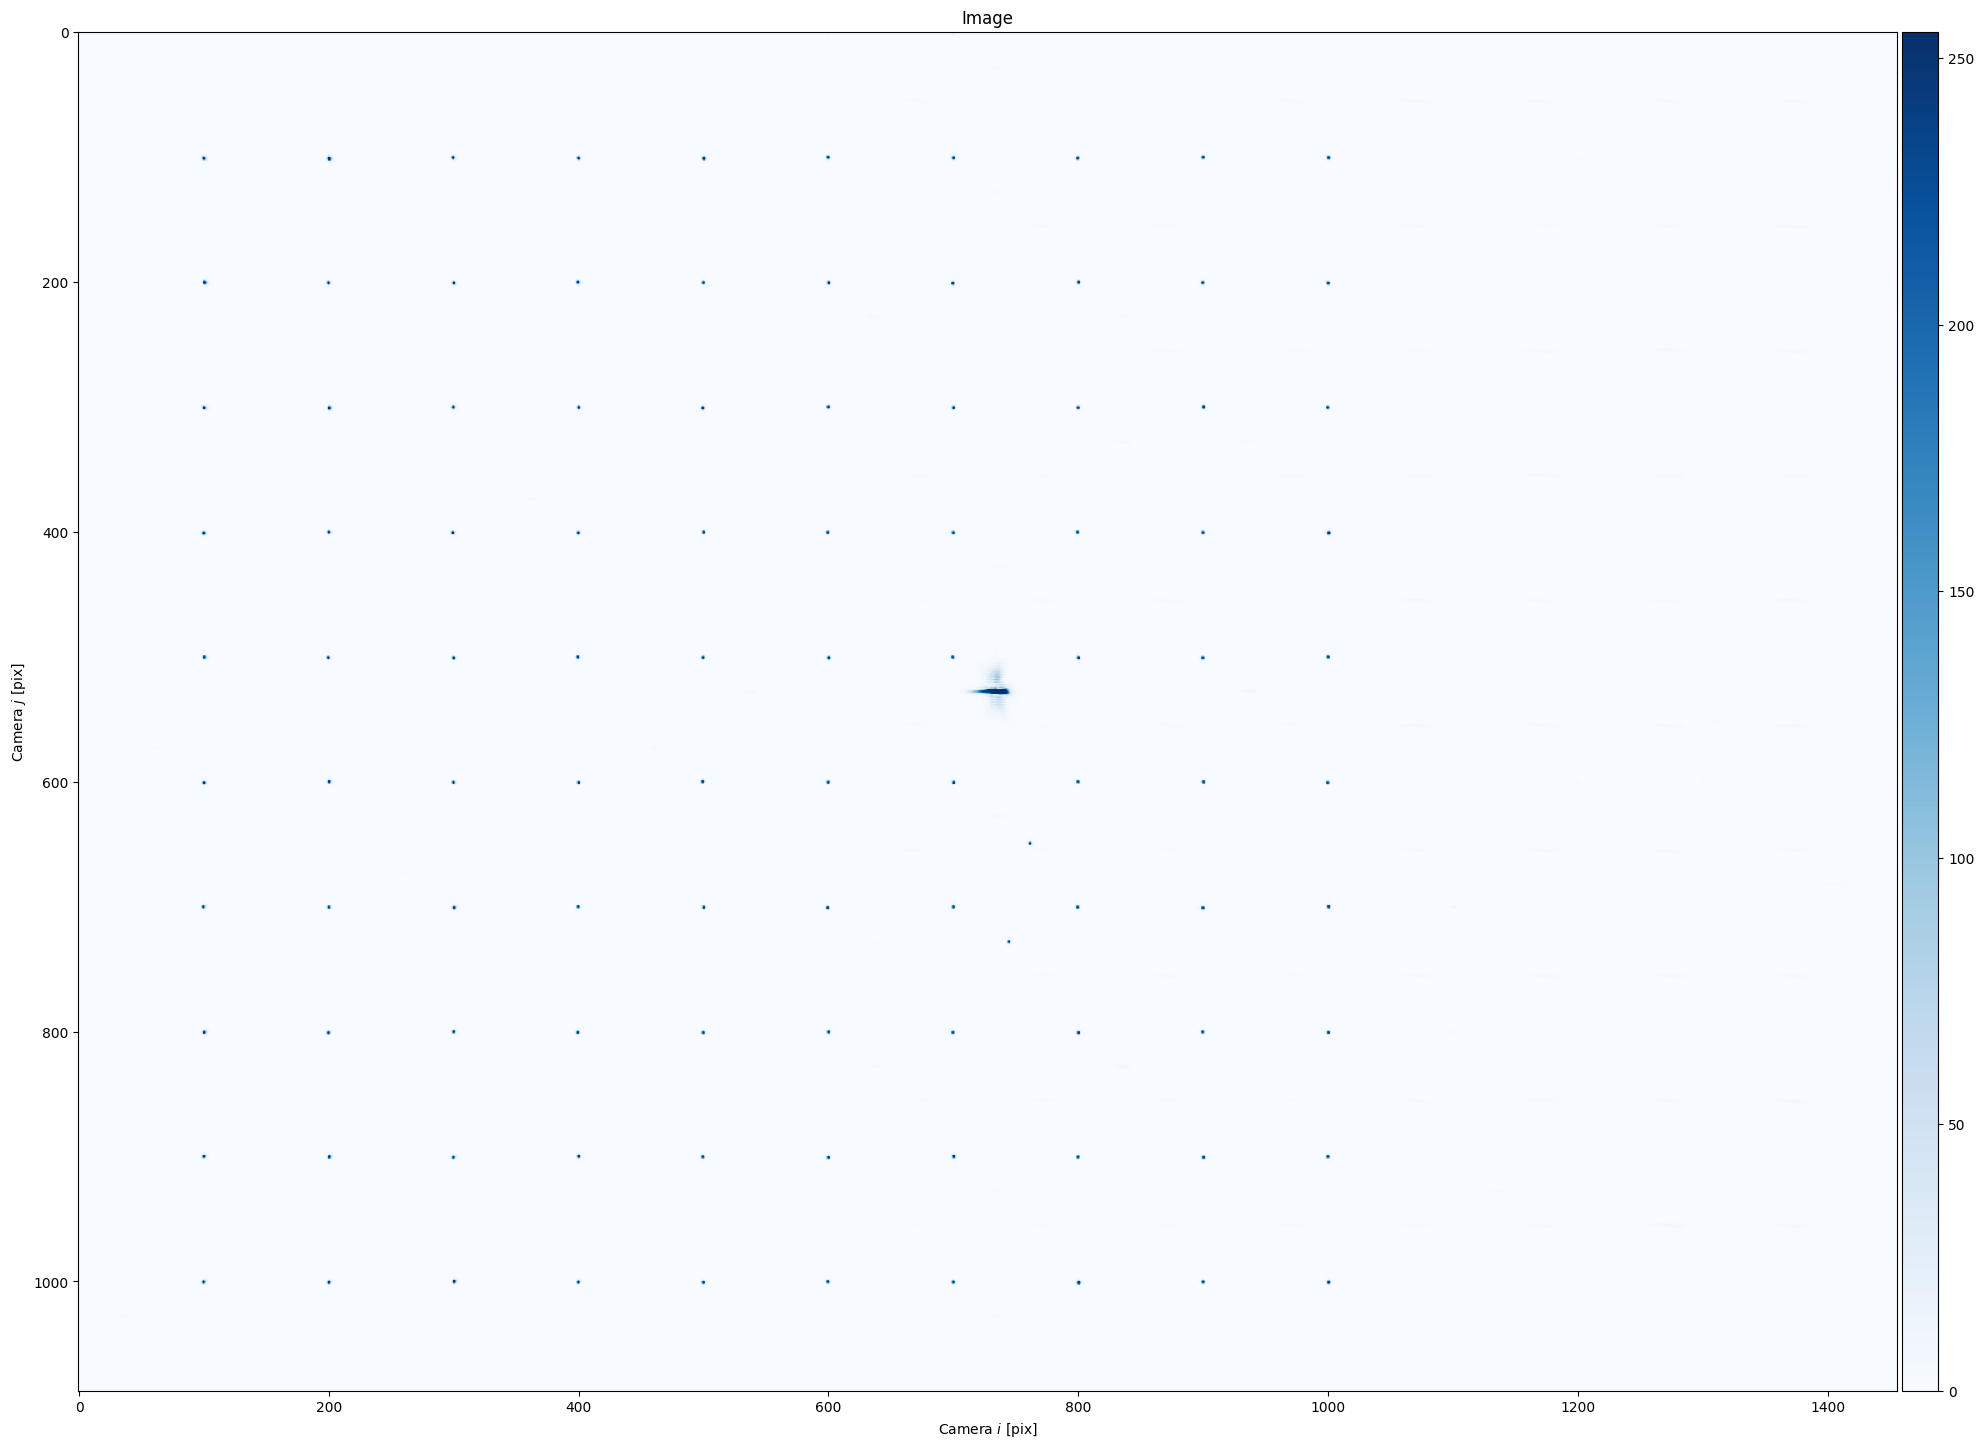

In [ ]:
img = fs.cam.get_image()                                        # Grab image (this time we dont' have to .set_phase() to the SLM, because the optimization did this already).

plt.figure(figsize=(24,24))
fs.cam.plot(img);

This looks more uniform, but it's hard to tell from the saturation. Let's take another look at the statistics of our array.

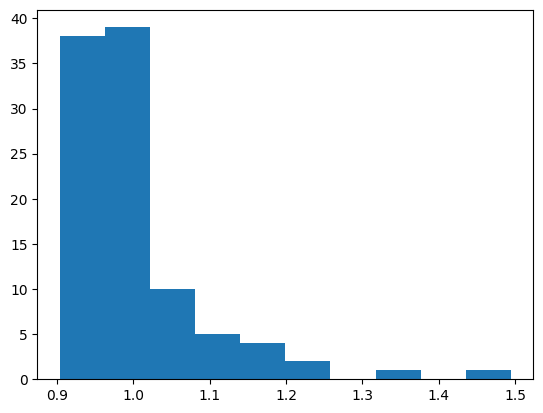

In [27]:
subimages = analysis.take(img, square, 25)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
plt.hist(power / np.mean(power)); plt.show()

Much more uniform. With the `stat_groups` parameter, we also asked the `SpotHologram` to note statistics as the optimization proceeded. We can plot these with the `.plot_stats()` function.

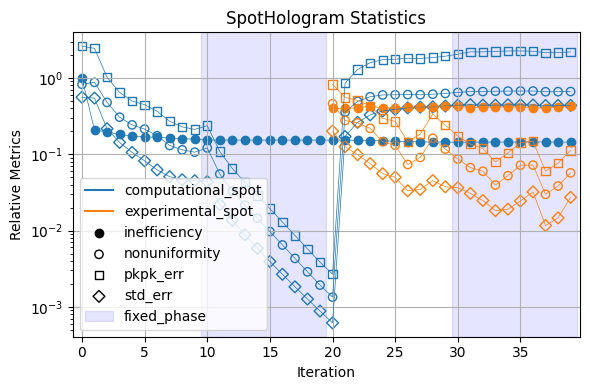

In [28]:
hologram.plot_stats();

This begs the question of what limits uniformity. In the case of this setup, it's likely the precision of our camera and the fact that power is concentrated on only a few of these 8-bit pixels.

#### A Scattered Example

[Lloyd's Algorithm](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) iteratively generates an array of spots spread across a given space. In this case, we want to generate a cloud of points within the field of view of our camera.

In [29]:
lloyds_points = toolbox.lloyds_points(grid=tuple(int(s/5) for s in fs.cam.shape), n_points=100, iterations=40) * 5

The `/5` and `*5` are for faster generation at the cost of rounding to every 5th pixel. Let's take a look at what we generated.

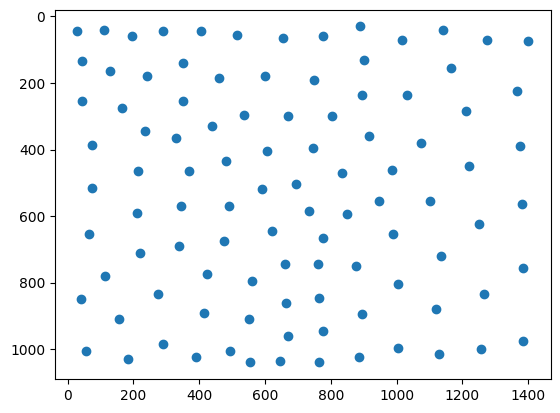

In [30]:
plt.scatter(lloyds_points[0, :], lloyds_points[1, :])
plt.gca().set_ylim(np.flip(plt.gca().get_ylim()))
plt.show()

We conduct the same process to optimize a hologram to generate this pattern.

In [31]:
hologram = SpotHologram((2048, 2048), lloyds_points, basis='ij', cameraslm=fs)

# Precondition computationally.
hologram.optimize(
    'WGS-Kim',
    maxiter=20,
    feedback='computational_spot',
    stat_groups=['computational_spot']
)
# Hone the result with experimental feedback.
hologram.optimize(
    'WGS-Kim',
    maxiter=20,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'],
    fixed_phase=False
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Let's again take a look at what we generated.

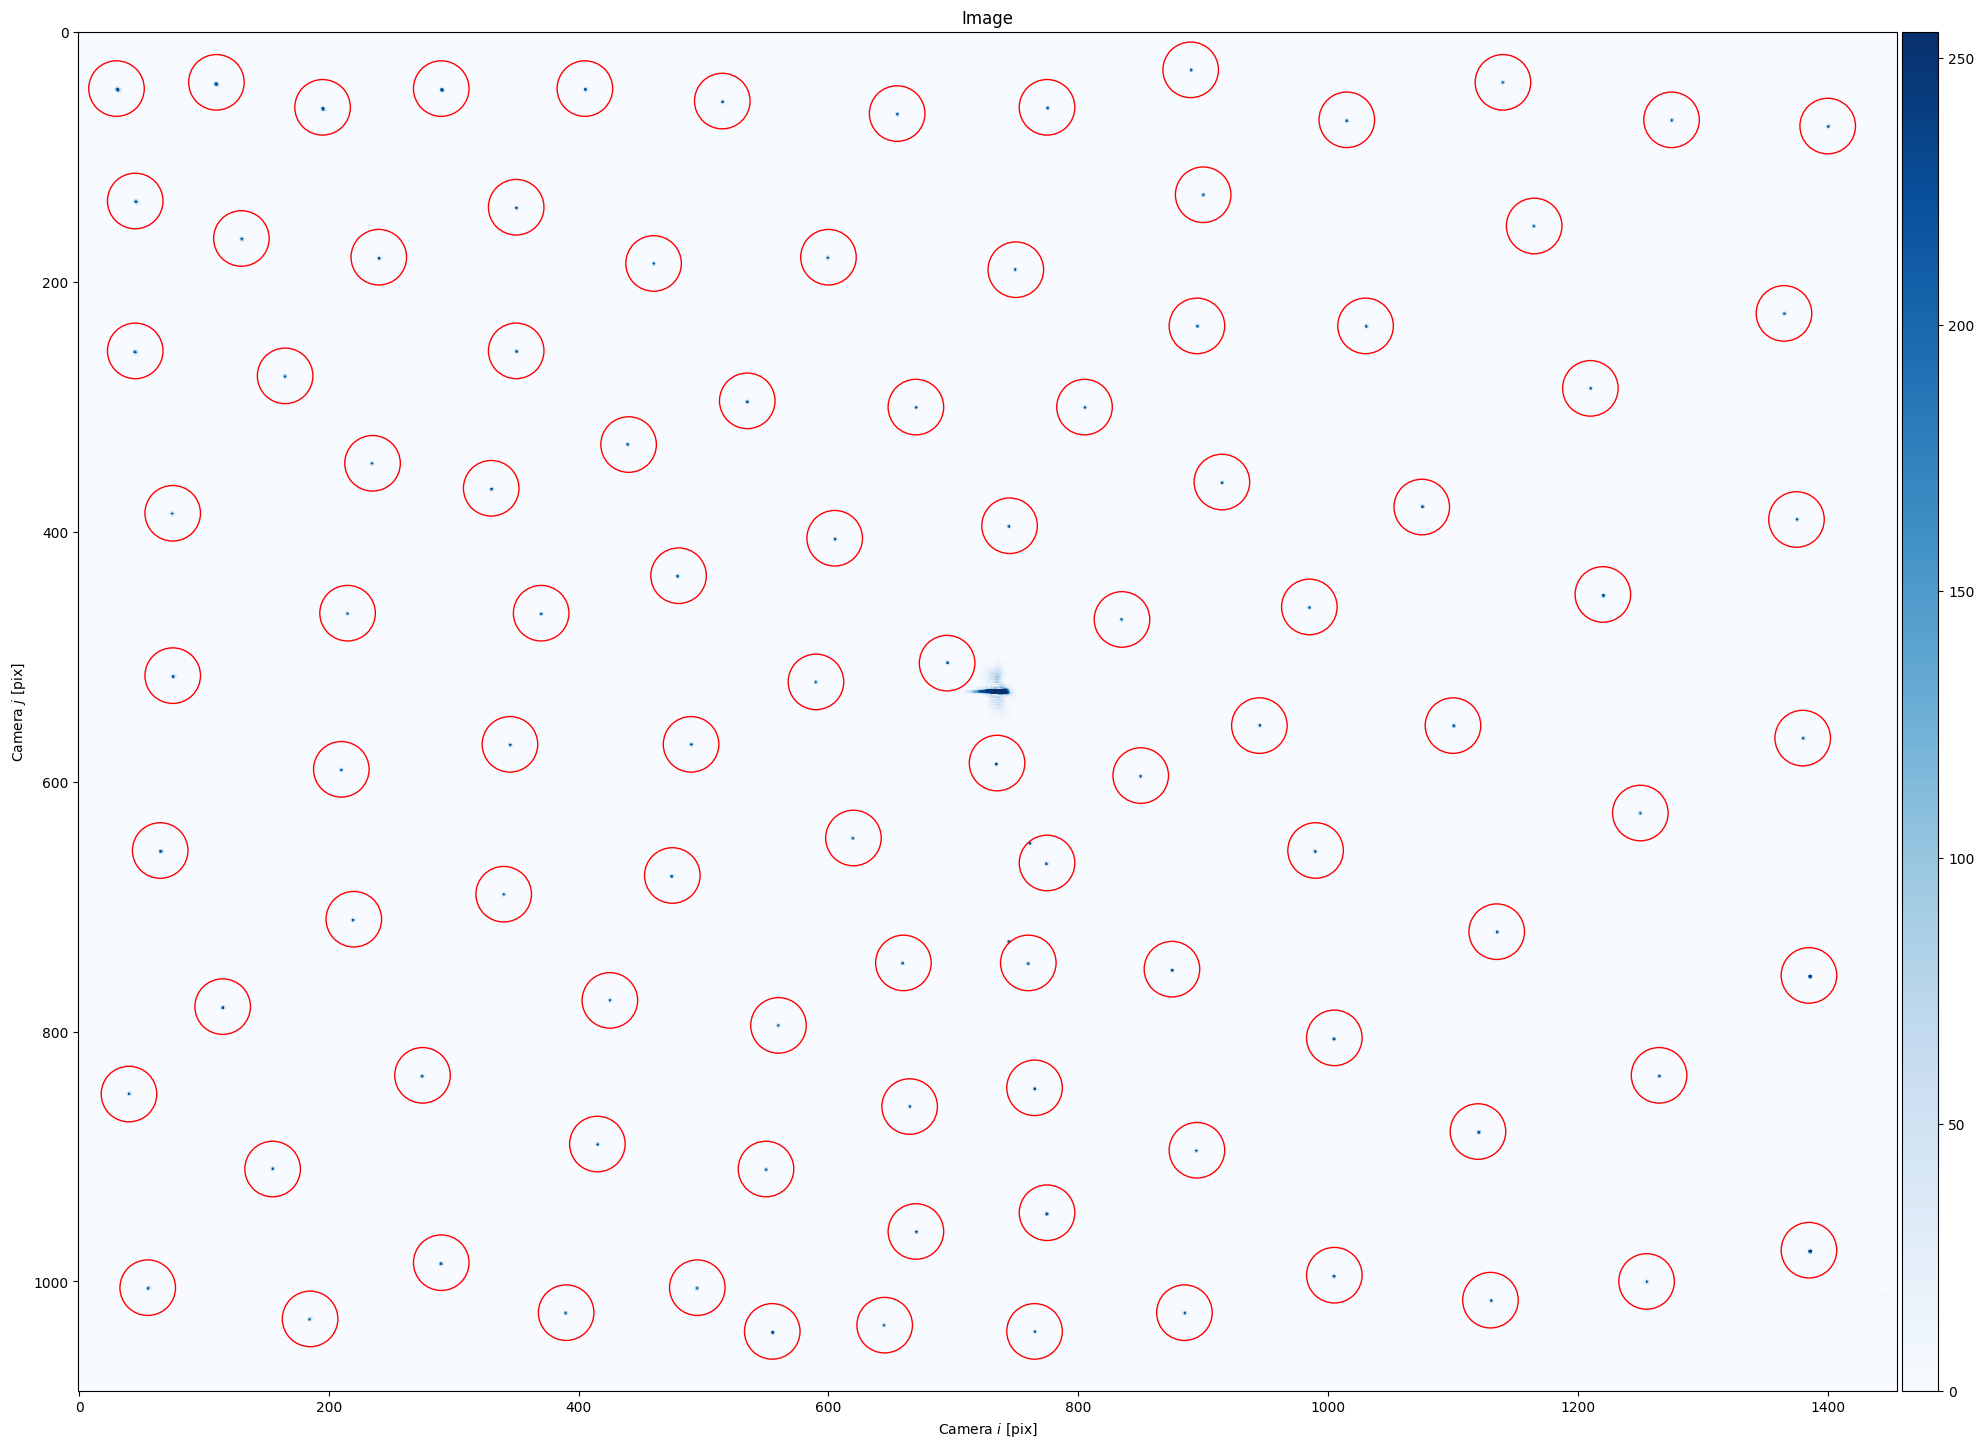

In [32]:
img = fs.cam.get_image()

plt.figure(figsize=(24,24))
ax = fs.cam.plot(img)
ax.scatter(lloyds_points[0, :], lloyds_points[1, :], 1600, facecolors='none', edgecolors='r')
plt.show()

Let's again take a look at the statistics. The optimization was faster, as expected for a pattern with less crystallinity.

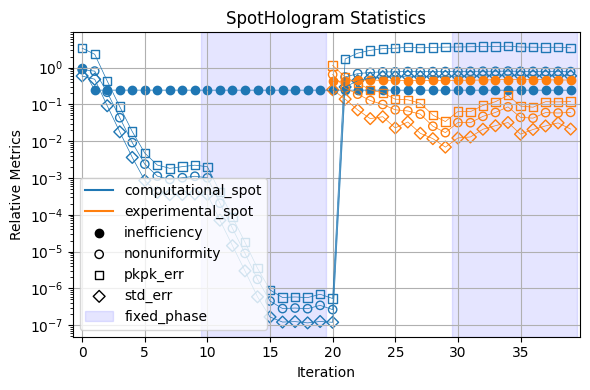

In [33]:
hologram.plot_stats();

#### Pictorial Holography

The spot holography we explored above is a subset of the general problem. In this section, we push further and look into forming images at desired positions in the camera's domain.

Let's start by loading a picture. We load an example helper function for this.

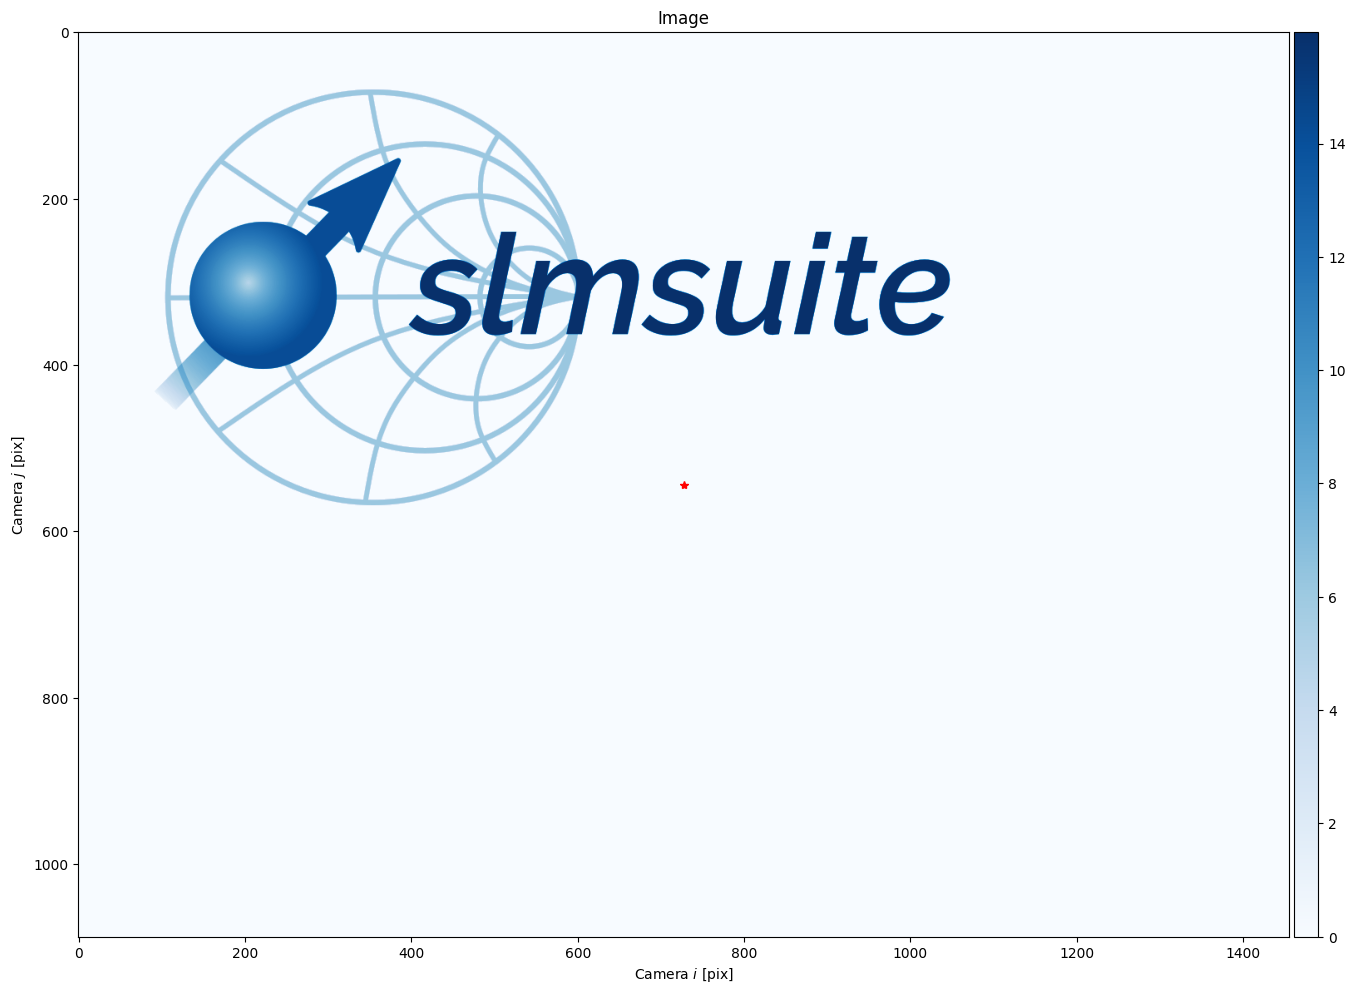

In [ ]:
from slmsuite.holography.analysis.files import _load_image

path = os.path.join(os.getcwd(), '../../slmsuite/docs/source/static/slmsuite-small.png')

target_ij = _load_image(path, fs.cam.shape, angle=0, shift=(-225, -170))

plt.figure(figsize=(16,12))
fs.cam.plot(target_ij)
plt.plot(target_ij.shape[1]/2, target_ij.shape[0]/2, 'r*');

Notice that the resulting image has the same shape as the camera. The goal is to replicate this pattern on the camera at the same position. We use similar syntax as before to initialize and optimize the hologram. This time we use a `FeedbackHologram`, which is actually the superclass of `SpotHologram`. `FeedbackHologram` is a subclass of `Hologram`, a class that only considers the abstract. `FeedbackHologram` has infrastructure to read in and interpret camera images. `SpotHologram` has infrastructure honed to optimize spot arrays. Let's take a look at our `FeedbackHologram`.

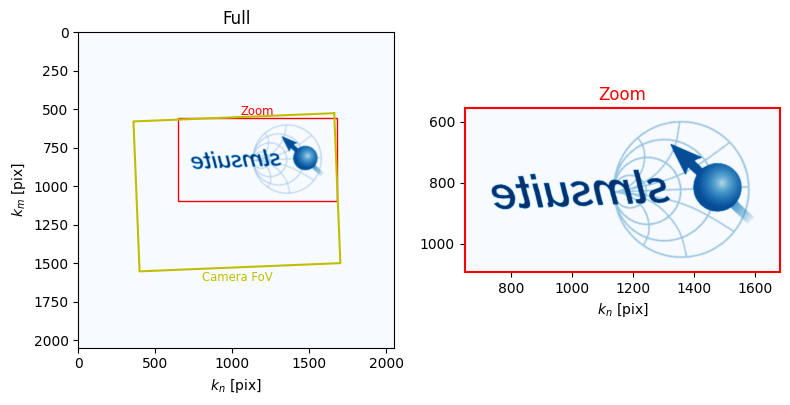

In [35]:
from slmsuite.holography.algorithms import FeedbackHologram
hologram = FeedbackHologram(shape=(2048, 2048), target_ij=target_ij, cameraslm=fs);
limits = hologram.plot_farfield(hologram.target); fs.cam.set_exposure(.2)
hologram.reset_phase(quadratic_phase=2)

We see how the image is imprinted upon the `"knm"` space in which the hologram is optimized. Now let's optimize it.

In [36]:
hologram.optimize(
    method="WGS-Leonardo",
    maxiter=10,
    feedback='computational',
    stat_groups=['computational']
)

  0%|          | 0/10 [00:00<?, ?it/s]

We quickly plot the image, and see our hologram! It looks alright.

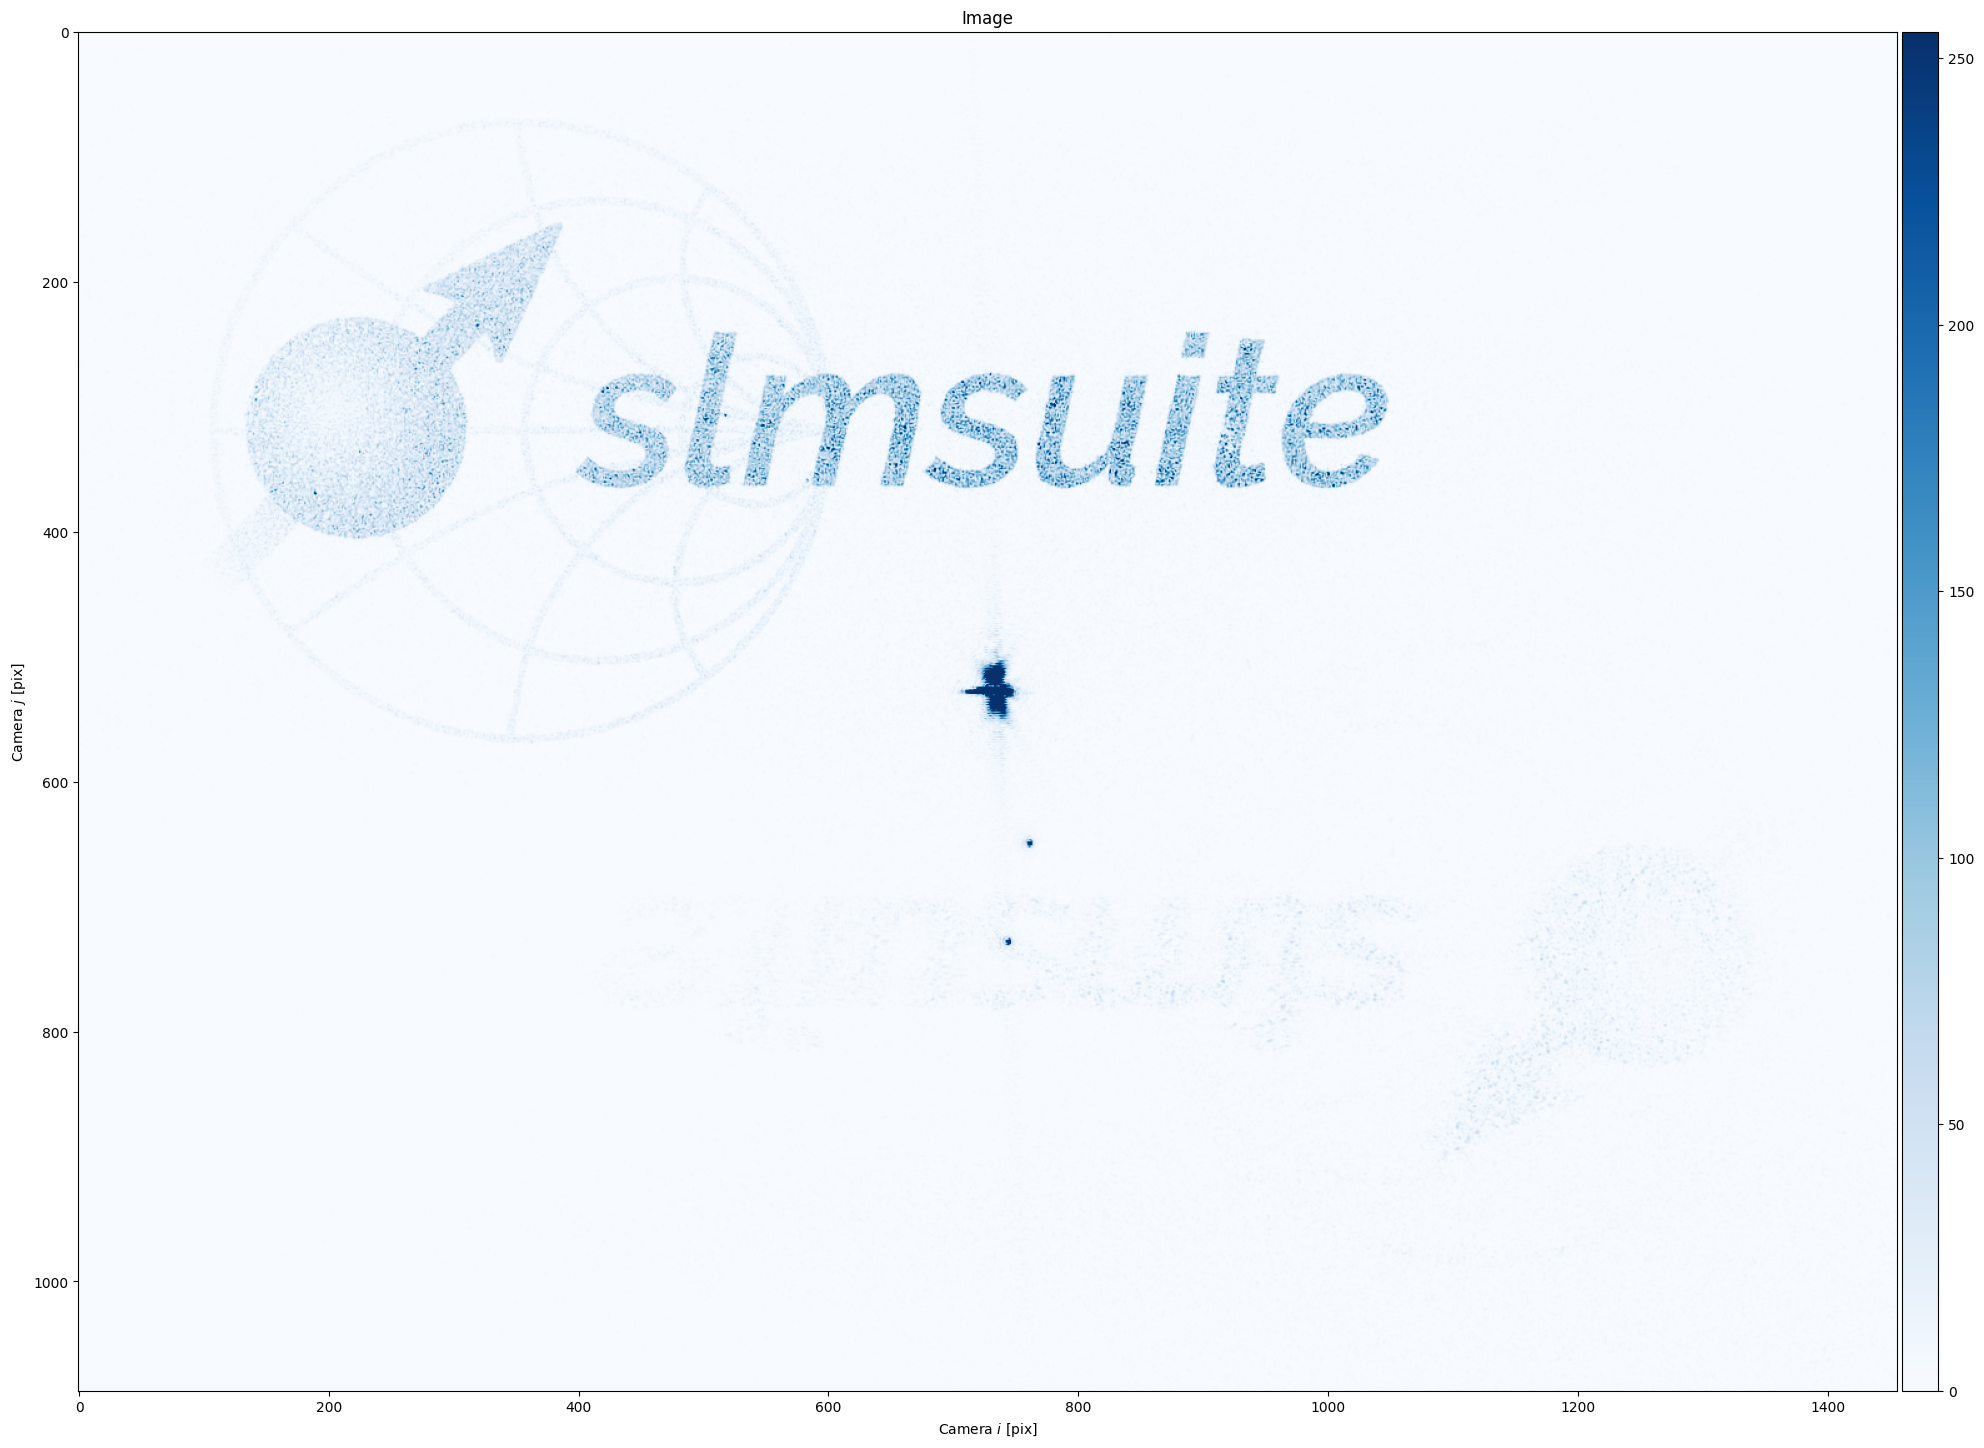

In [37]:
fs.slm.write(hologram.get_phase(), settle=True)

plt.figure(figsize=(24,24))
fs.cam.plot();

This is the phase that produces that result.

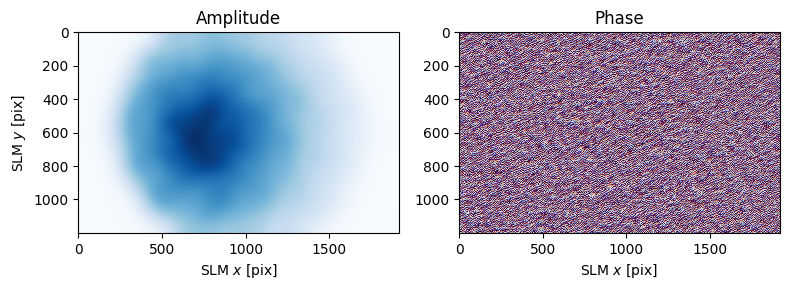

In [38]:
hologram.plot_nearfield()

We can also take a look at the hologram computationally, i.e. the expected result from Fourier-transforming the nearfield. Notice that there is some power in the field, and we need to use the `limits` from the previous `.plot_farfield()` to get the zoom box to not be the whole domain.

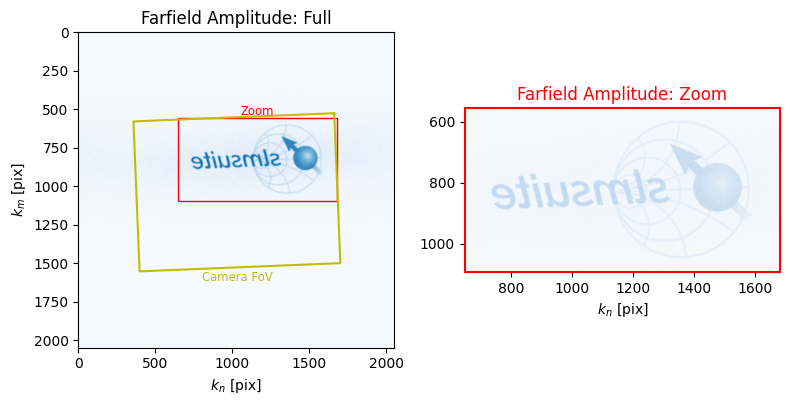

In [39]:
hologram.plot_farfield(limits=limits);

We can push this a bit further by again applying camera feedback, this time to the whole image.

In [40]:
hologram.optimize(
    method="WGS-Leonardo",
    maxiter=10,
    feedback='experimental',
    stat_groups=['computational', 'experimental'],
    blur_ij=1
)

  0%|          | 0/10 [00:00<?, ?it/s]

The hologram appears with higher fidelity, though speckle remains a concern.

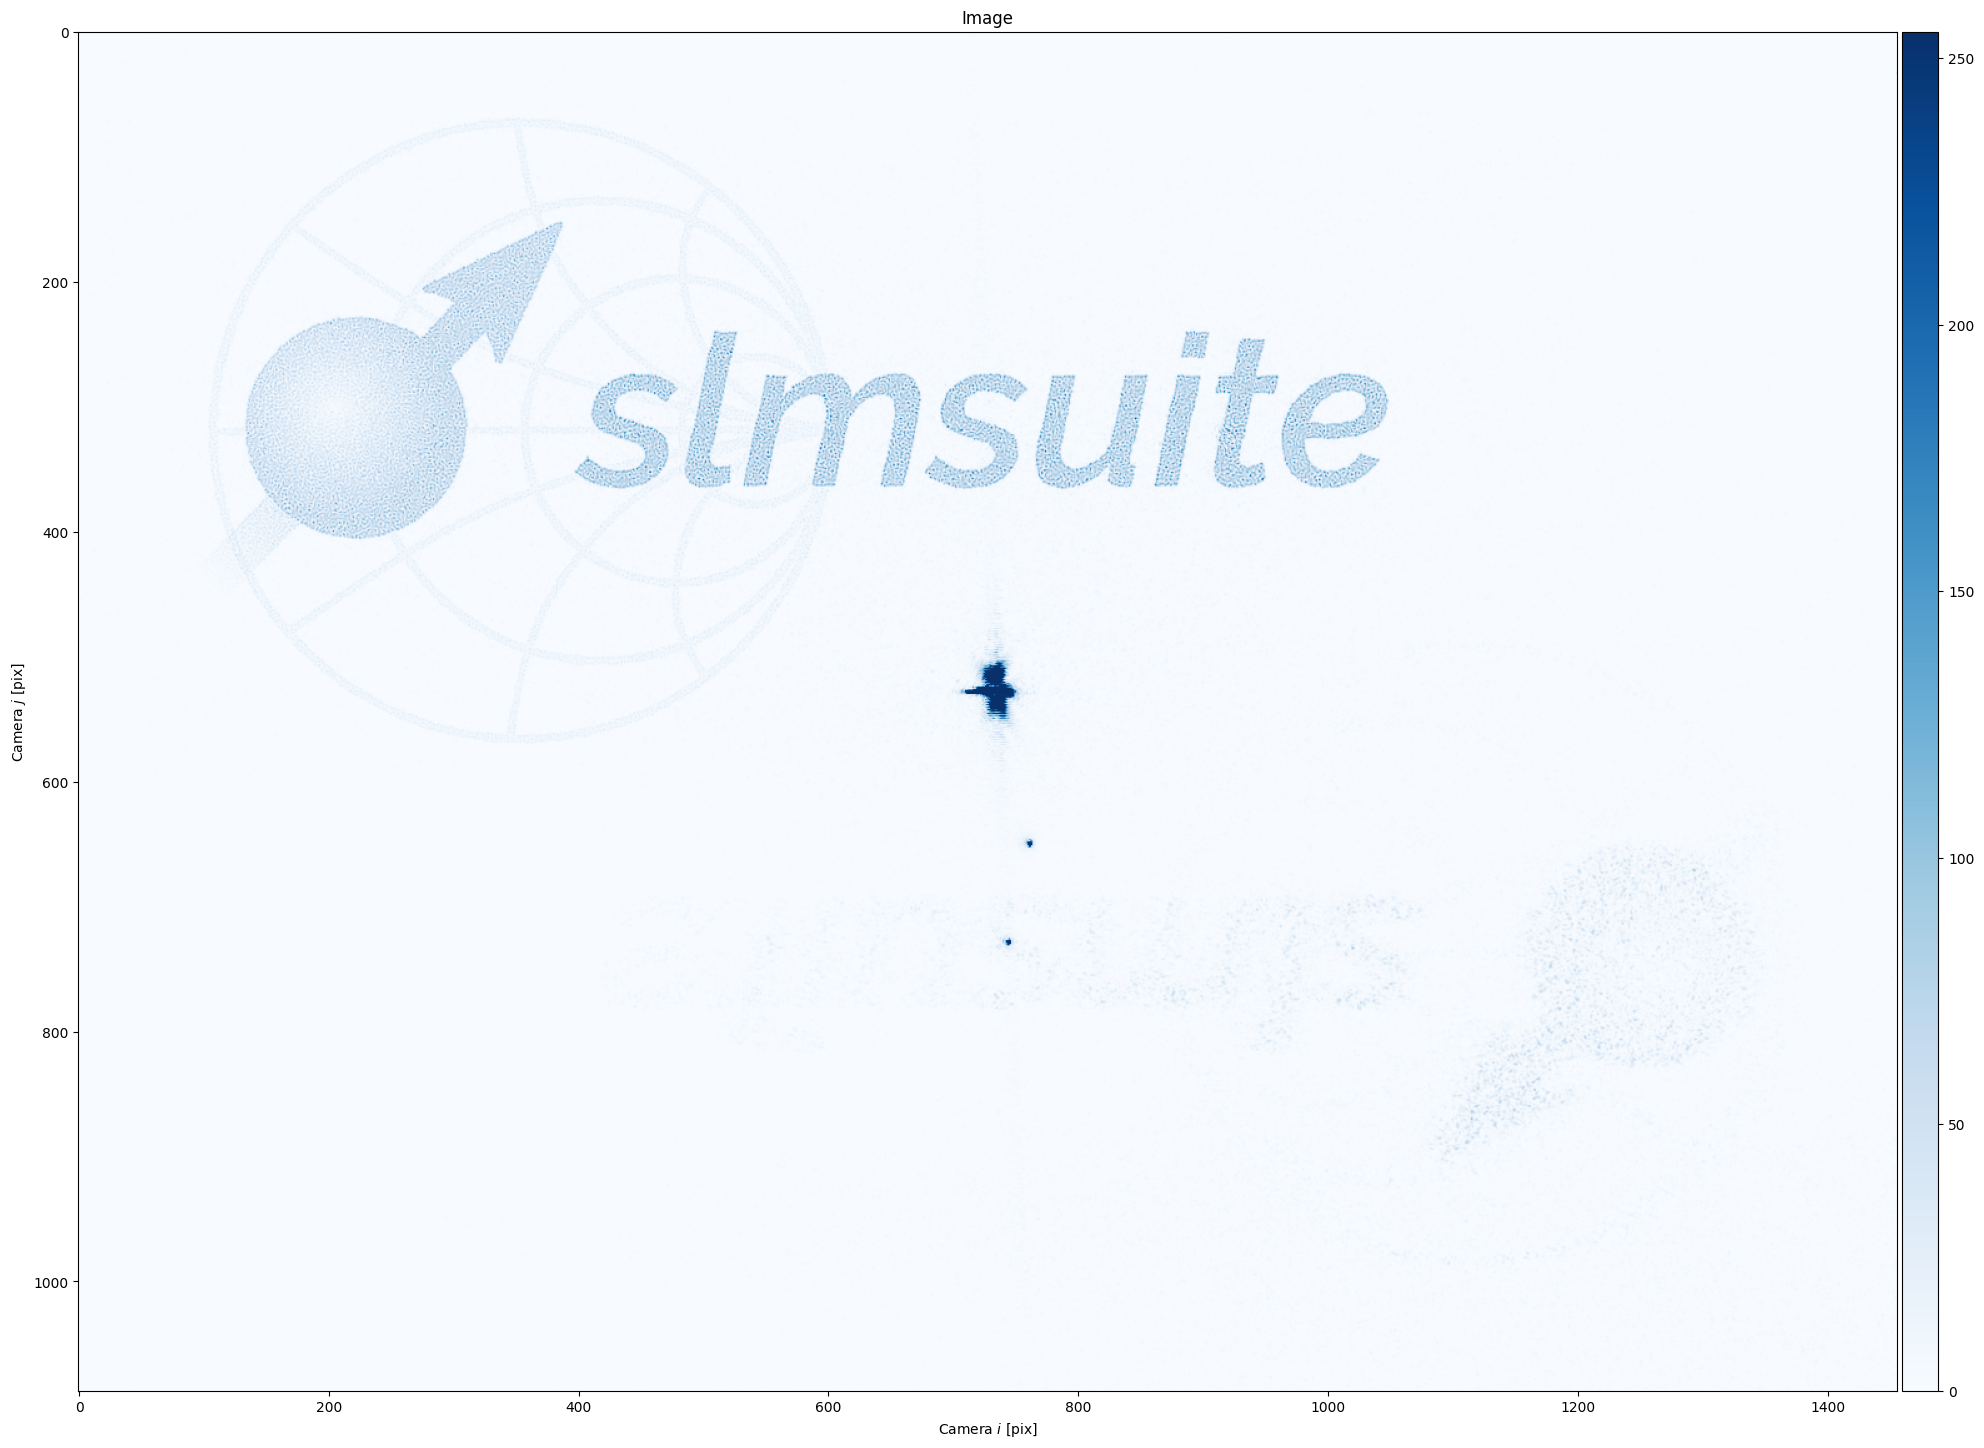

In [ ]:
fs.slm.set_phase(hologram.get_phase(), settle=True)
fs.cam.flush()
img = fs.cam.get_image()

plt.figure(figsize=(24,24))
fs.cam.plot(img);

We look forward to seeing what sort of holograms you'll make!